In [1]:
!nvidia-smi

Sat Sep 21 17:43:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.28                 Driver Version: 537.28       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   43C    P8               1W /  50W |    224MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Object Detection using YOLOV7

## Import Libraries and Modules

In [2]:
# YOLOv7 specific imports
from models.experimental import attempt_load
from utils.general import check_img_size, non_max_suppression, scale_coords
from utils.torch_utils import select_device

# bytetrack imports
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch

# to load the model and processing of the image
import cv2
import torch
import numpy as np
from typing import Dict, Tuple, List
from dataclasses import dataclass

# specific import for annotating the frame
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.draw.color import ColorPalette
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator
from supervision.geometry.dataclasses import Point

# to save the output video
from tqdm import tqdm  

## Parameters

In [10]:
@dataclass
class Config:
    MODEL_PATH: str = "yolov7.pt"  
    CONFIDENCE_THRESHOLD: float = 0.5
    IOU_THRESHOLD: float = 0.3
    FONT_SCALE: float = 1
    FONT_THICKNESS: int = 2

config = Config()

@dataclass
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Detections Class

The Detections class is a custom data structure designed to store and manage the results of object detection.

In [4]:
class Detections:
    def __init__(self, xyxy, confidence, class_id, tracker_id=None):
        self.xyxy = np.array(xyxy)  # Ensure it's a NumPy array
        self.confidence = np.array(confidence)  # Ensure it's a NumPy array
        self.class_id = np.array(class_id)  # Ensure it's a NumPy array
        self.tracker_id = np.array(tracker_id) if tracker_id is not None else np.array([None] * len(xyxy))

    def filter(self, mask, inplace=False):
        if not isinstance(mask, np.ndarray) or mask.dtype != bool:
            raise ValueError("Mask should be a boolean NumPy array")
        
        if inplace:
            self.xyxy = self.xyxy[mask]
            self.confidence = self.confidence[mask]
            self.class_id = self.class_id[mask]
            if self.tracker_id is not None:
                self.tracker_id = self.tracker_id[mask]
        else:
            return Detections(
                self.xyxy[mask],
                self.confidence[mask],
                self.class_id[mask],
                self.tracker_id[mask] if self.tracker_id is not None else None
            )

    def __iter__(self):
        for xyxy, confidence, class_id, tracker_id in zip(
            self.xyxy, self.confidence, self.class_id, self.tracker_id
        ):
            yield xyxy, confidence, class_id, tracker_id


## Object Detection 

In [5]:
class ObjectDetector:
        def __init__(self, config: Config):
            self.config = config
            self.device = select_device('')
            self.model = self._load_model()
            self.imgsz = check_img_size(640, s=self.model.stride.max())
            self.byte_tracker = BYTETracker(BYTETrackerArgs())
            self.cross_counter = 0
            self.previous_positions = {}

        # loading the model
        def _load_model(self) -> torch.nn.Module:
            model = attempt_load(self.config.MODEL_PATH, map_location=self.device)
            return model
        # resiving the frame for it to satisfies the model requirement
        def resize_image(self, frame: np.ndarray) -> torch.Tensor:
            img = cv2.resize(frame, (self.imgsz, self.imgsz))
            img = img.transpose((2, 0, 1))[::-1]  
            img = np.ascontiguousarray(img)
            img = torch.from_numpy(img).to(self.device)
            img = img.float() / 255.0
            if img.ndimension() == 3:
                img = img.unsqueeze(0)
            return img

        # manually match the bounding boxes coming from our model with those created by the tracker. 
        
        # converts Detections into format that can be consumed by match_detections_with_tracks function
        @staticmethod
        def detections2boxes(detections: Detections) -> np.ndarray:
            return np.hstack((
                detections.xyxy,
                detections.confidence[:, np.newaxis]
            ))

        # converts List[STrack] into format that can be consumed by match_detections_with_tracks function
        @staticmethod
        def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
            return np.array([
                track.tlbr
                for track in tracks
            ], dtype=float)

        # matches our bounding boxes with predictions
        @staticmethod
        def match_detections_with_tracks(
                detections: Detections,
                tracks: List[STrack]
        ) -> List[int]:
            if not np.any(detections.xyxy) or len(tracks) == 0:
                return [None] * len(detections.xyxy)
    
            tracks_boxes = ObjectDetector.tracks2boxes(tracks=tracks)
            iou = box_iou_batch(tracks_boxes, detections.xyxy)
            track2detection = np.argmax(iou, axis=1)
    
            tracker_ids = [None] * len(detections.xyxy)
    
            for tracker_index, detection_index in enumerate(track2detection):
                if iou[tracker_index, detection_index] != 0:
                    tracker_ids[detection_index] = tracks[tracker_index].track_id
    
            return tracker_ids

       # function for processing the frame (detection and annotating the bounding boxes and labels)
        def process_frame(self, frame: np.ndarray) -> Tuple[np.ndarray, float, Dict[int, str]]:
            CLASS_NAMES_DICT = self.model.module.names if hasattr(self.model, 'module') else self.model.names
            CLASS_ID = [1,2,3,5,7]
            height, width = frame.shape[:2]

            # Define the vertical offset (e.g., 50 pixels down from the middle)
            offset = 200
            
            # Line start: left side of the frame, offset down from the middle
            LINE_START = (0, int(height / 2) + offset)
            
            # Line end: right side of the frame, offset down from the middle
            LINE_END = (width, int(height / 2) + offset)

            img = self.resize_image(frame) 
            img_shape = img.shape[2:]
            frame_shape = frame.shape
            print(f"Resized image dimensions: {img_shape}")
            print(f"Original frame dimensions: {frame_shape}")
            with torch.no_grad():
                pred = self.model(img, augment=False)[0]
                
            pred = non_max_suppression(pred, self.config.CONFIDENCE_THRESHOLD, self.config.IOU_THRESHOLD)
            if torch.cuda.is_available():
                torch.cuda.synchronize()   
                
            if len(pred[0]) > 0:
                det = pred[0]
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], frame.shape).round()
                # print(f"Original coordinates: {det[:, :4]}")
                # print(f"Scaled coordinates: {det[:, :4].cpu().numpy()}")
                # Custom Detections class as you defined
                detections = Detections(
                    xyxy=det[:, :4].cpu().numpy(),
                    confidence=det[:, 4].cpu().numpy(),
                    class_id=det[:, 5].cpu().numpy().astype(int)
                )

                tracks = self.byte_tracker.update(
                    output_results=self.detections2boxes(detections=detections),
                    img_info=frame.shape,
                    img_size=frame.shape)
                tracker_id = self.match_detections_with_tracks(detections=detections, tracks=tracks)
                detections.tracker_id = np.array(tracker_id)
                
                mask = np.array([(class_id in CLASS_ID) and (tracker_id is not None)
                 for class_id, tracker_id in zip(detections.class_id, detections.tracker_id)], dtype=bool)
                detections.filter(mask=mask, inplace=True)
                
                # line_counter = LineCounter(start=self.config.LINE_START, end=self.config.LINE_END)
                # line_annotator = LineCounterAnnotator(thickness=2, text_thickness=2, text_scale=2)
                box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=2, text_scale=2)

                # line_counter.update(detections=detections)
                # line_annotator.annotate(frame=frame, line_counter=line_counter)
                # for xyxy, confidence, class_id, tracker_id in detections:
                #     x1, y1, x2, y2 = xyxy.astype(int)
                #     class_name = CLASS_NAMES_DICT[class_id]
                #     color = self.get_color_for_class(CLASS_ID)
                #     label = f"#{class_name} {confidence:.2f}"
                #     cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                #     cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                    # print(f"Drawing box: {x1}, {y1}, {x2}, {y2}, label: {label}")


        
                # Create detection_objects and labels
                detection_objects = [(xyxy.astype(int), conf, cls_id, track_id)  
                                     for xyxy, conf, cls_id, track_id in zip(detections.xyxy, detections.confidence, detections.class_id, detections.tracker_id)]
                
                labels = [f"ID {track_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
                          for confidence, class_id, track_id in zip(detections.confidence, detections.class_id, detections.tracker_id)]
                
                # Iterate through detection_objects and labels
                for (xyxy, conf, cls_id, track_id), label in zip(detection_objects, labels):
                    x1, y1, x2, y2 = xyxy  
                    print(f"Drawing box: {x1}, {y1}, {x2}, {y2}, label: {label}")

                    # Ensure tracker_id is not None
                    if track_id is not None:
                        current_position = (int((x1 + x2) / 2), int((y1 + y2) / 2))
                
                        # Check if this track_id already exists in previous_positions
                        if track_id in self.previous_positions:
                            previous_position = self.previous_positions[track_id]
                
                            # Check if the object has crossed the line
                            if previous_position[1] < LINE_START[1] and current_position[1] >= LINE_START[1]:
                                self.cross_counter += 1
                
                        # Update the previous position for this track_id
                        self.previous_positions[track_id] = current_position
                
                cv2.line(frame, LINE_START, LINE_END, (0, 255, 0), 2)
                cv2.putText(frame, f"Cross Counter: {self.cross_counter}", (10, frame.shape[0] - 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                # Annotate the frame with boxes and labels
                frame = box_annotator.annotate(frame=frame, detections=detection_objects, labels=labels)

            return frame
                
            

## Inferencing an Image

In [6]:
def main(image_input):
    detector = ObjectDetector(config)
    frame = cv2.imread(image_input)
    if frame is None:
        raise RuntimeError("Error: Could not open image.")
    processed_frame = detector.process_frame(frame)

    # Display the frame in a Jupyter notebook
    %matplotlib inline
    show_frame_in_notebook(frame, (16, 16))
    

## Inferencing a Video

In [7]:
def frame_generator(cap):
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        yield frame

def main2(video_input, video_output):
    cap = cv2.VideoCapture(video_input)
    if not cap.isOpened():
        raise RuntimeError("Error: Could not open video capture.")
    detector = ObjectDetector(config)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_gen = frame_generator(cap)
    pbar = tqdm(frame_gen, total=total_frames, desc="Processing Frames")
    fps = cap.get(cv2.CAP_PROP_FPS)
    input_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    input_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(video_output, fourcc, fps, (input_width, input_height))

    try:
        for frame in pbar:
            if frame is None:
                break

            processed_frame = detector.process_frame(frame)
            out.write(processed_frame)
    
    except Exception as e:
        logger.exception(f"An error occurred: {e}") 
    finally:
        cap.release()
        out.release()
        torch.cuda.empty_cache()


## Example

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (825, 1897, 3)
Drawing box: 1354, 360, 1895, 825, label: ID 22 truck 0.94
Drawing box: 876, 455, 1473, 825, label: ID 23 truck 0.89
Drawing box: 818, 186, 979, 384, label: ID 24 truck 0.62


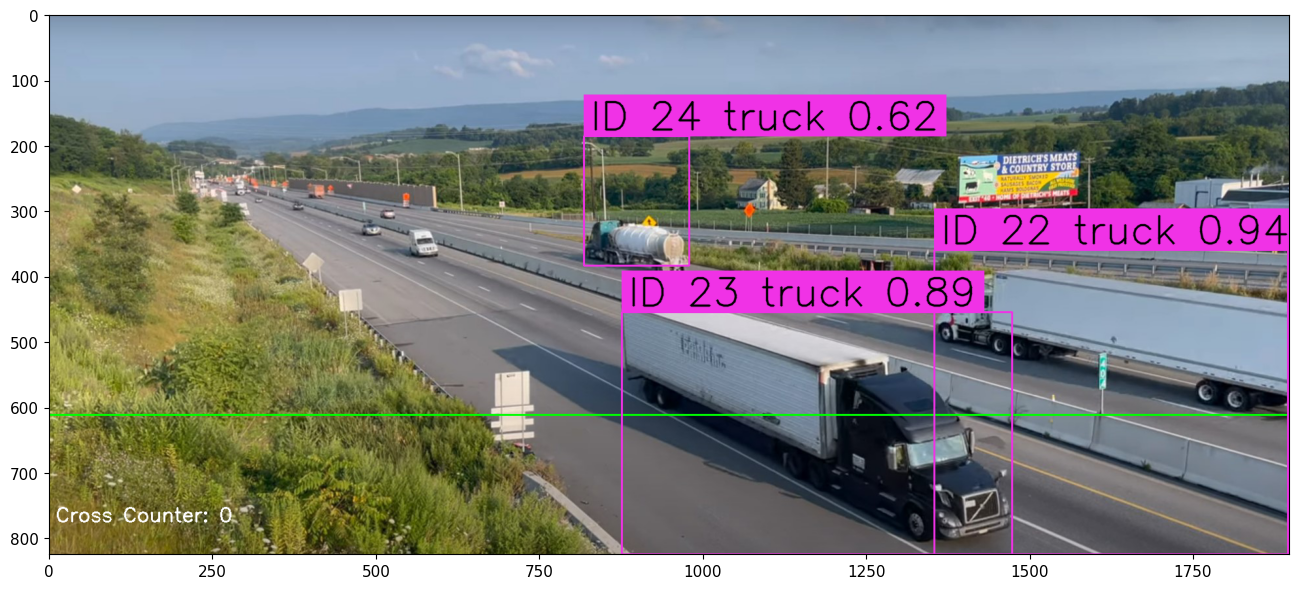

In [11]:
if __name__ == "__main__":
    image_input = "5.jpg"
    main(image_input)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (2160, 3840, 3)
Drawing box: 1212, 208, 1763, 1235, label: ID 38 truck 0.96
Drawing box: 3201, 175, 3574, 974, label: ID 26 truck 0.94
Drawing box: 4, 782, 882, 2160, label: ID 27 truck 0.94
Drawing box: 1464, 1448, 1838, 1998, label: ID 28 car 0.93
Drawing box: 3048, 872, 3340, 1364, label: ID 29 truck 0.92
Drawing box: 1834, 832, 2096, 1183, label: ID 30 car 0.92
Drawing box: 2933, 1394, 3263, 1875, label: ID 31 car 0.88
Drawing box: 2246, 0, 2421, 67, label: ID 32 truck 0.85
Drawing box: 2167, 324, 2349, 582, label: ID 33 car 0.79
Drawing box: 2370, 109, 2472, 271, label: ID 35 car 0.69


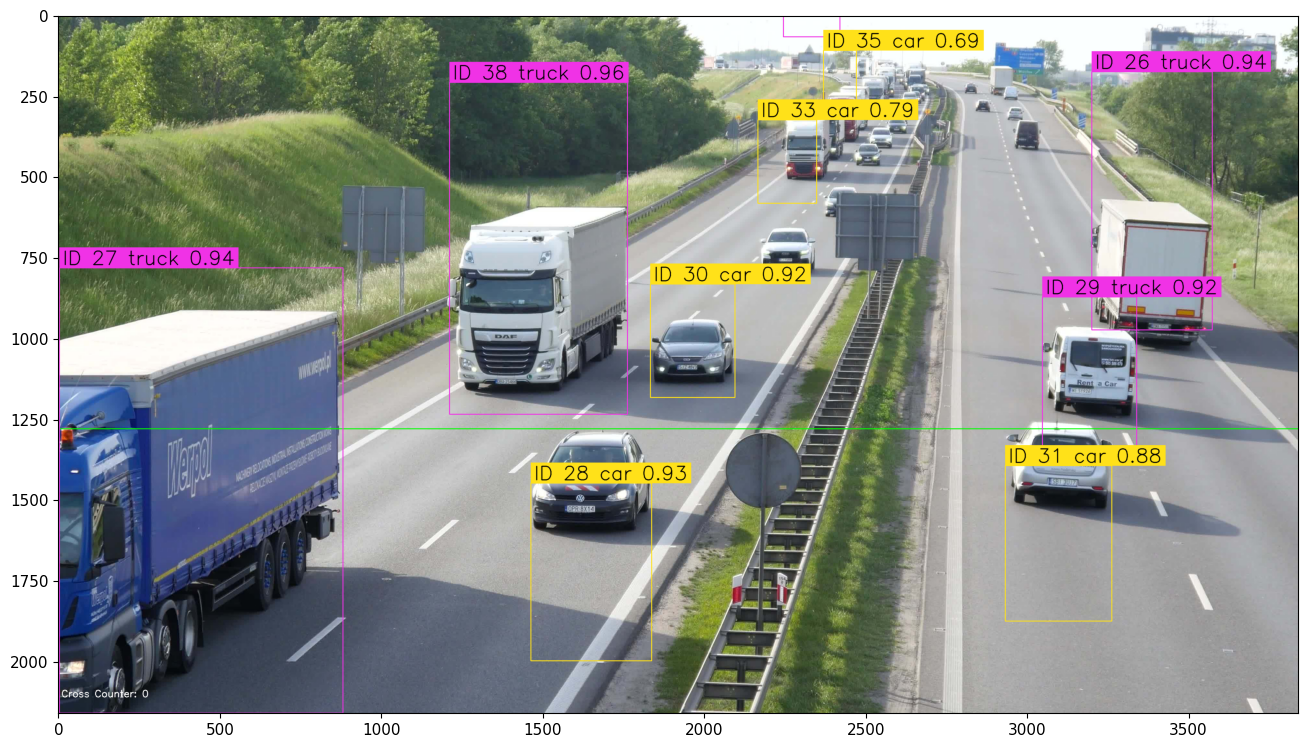

In [12]:
if __name__ == "__main__":
    image_input = "24.jpg"
    main(image_input)

## Video Sample

In [33]:
if __name__ == "__main__":
    video_input = "Cars.mp4"
    video_output = "Cars_bout.mp4"
    main2(video_input, video_output)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


Processing Frames:   0%|                                                                       | 0/716 [00:00<?, ?it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   0%|▏                                                              | 2/716 [00:00<01:36,  7.40it/s]

Drawing box: 1058, 307, 1376, 991, label: ID 11703 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1066, 332, 1398, 1080, label: ID 11701 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1074, 357, 1423, 1080, label: ID 11701 car 0.82


Processing Frames:   0%|▎                                                              | 3/716 [00:00<01:25,  8.36it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1077, 423, 1453, 1080, label: ID 11701 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   1%|▍                                                              | 5/716 [00:00<01:19,  9.00it/s]

Drawing box: 1081, 489, 1482, 1080, label: ID 11701 car 0.84


Processing Frames:   1%|▌                                                              | 6/716 [00:00<01:18,  9.03it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   1%|▊                                                              | 9/716 [00:00<01:12,  9.76it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1294, 0, 1456, 23, label: ID 11716 car 0.81
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1299, 0, 1468, 57, label: ID 11716 car 0.72
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   2%|█                                                             | 12/716 [00:01<01:13,  9.60it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1311, 0, 1490, 111, label: ID 11720 car 0.70
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1321, 0, 1505, 131, label: ID 11720 car 0.81


Processing Frames:   2%|█▏                                                            | 14/716 [00:01<01:10,  9.92it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1328, 0, 1519, 157, label: ID 11720 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1334, 0, 1533, 193, label: ID 11720 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   2%|█▍                                                            | 16/716 [00:01<01:08, 10.24it/s]

Drawing box: 1344, 0, 1548, 222, label: ID 11720 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1350, 0, 1565, 263, label: ID 11720 car 0.93
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1362, 0, 1583, 294, label: ID 11720 car 0.89


Processing Frames:   3%|█▌                                                            | 18/716 [00:01<01:06, 10.49it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1372, 0, 1601, 335, label: ID 11720 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1380, 0, 1621, 367, label: ID 11720 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   3%|█▉                                                            | 22/716 [00:02<01:05, 10.61it/s]

Drawing box: 1392, 0, 1642, 411, label: ID 11720 car 0.91
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1404, 14, 1666, 457, label: ID 11720 car 0.91
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1417, 41, 1691, 509, label: ID 11720 car 0.93


Processing Frames:   3%|██                                                            | 24/716 [00:02<01:04, 10.74it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1429, 72, 1719, 565, label: ID 11720 car 0.94
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1445, 106, 1749, 619, label: ID 11720 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   4%|██▎                                                           | 26/716 [00:02<01:04, 10.78it/s]

Drawing box: 1463, 136, 1784, 682, label: ID 11720 car 0.95
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1481, 177, 1824, 756, label: ID 11720 car 0.94
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1500, 219, 1865, 837, label: ID 11720 car 0.95


Processing Frames:   4%|██▍                                                           | 28/716 [00:02<01:03, 10.78it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1520, 264, 1908, 921, label: ID 11720 car 0.93
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1538, 311, 1920, 1015, label: ID 11720 car 0.93
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   4%|██▌                                                           | 30/716 [00:02<01:04, 10.71it/s]

Drawing box: 1559, 363, 1919, 1080, label: ID 11720 car 0.92
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1586, 414, 1919, 1080, label: ID 11720 car 0.94
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1613, 469, 1919, 1080, label: ID 11720 car 0.89


Processing Frames:   5%|██▉                                                           | 34/716 [00:03<01:03, 10.80it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1643, 537, 1919, 1080, label: ID 11720 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1681, 611, 1919, 1080, label: ID 11720 car 0.81
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   5%|███                                                           | 36/716 [00:03<01:02, 10.88it/s]

Drawing box: 1720, 689, 1919, 1080, label: ID 11720 car 0.67
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   5%|███▎                                                          | 38/716 [00:03<01:01, 10.96it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   6%|███▋                                                          | 42/716 [00:04<01:01, 11.03it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   6%|███▊                                                          | 44/716 [00:04<01:01, 11.01it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   7%|████▏                                                         | 48/716 [00:04<01:00, 11.01it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   7%|████▎                                                         | 50/716 [00:04<00:59, 11.10it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   8%|████▋                                                         | 54/716 [00:05<00:58, 11.24it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   8%|████▊                                                         | 56/716 [00:05<00:58, 11.20it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   8%|█████▏                                                        | 60/716 [00:05<00:58, 11.25it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   9%|█████▎                                                        | 62/716 [00:05<00:58, 11.27it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   9%|█████▋                                                        | 66/716 [00:06<00:57, 11.27it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:   9%|█████▉                                                        | 68/716 [00:06<00:57, 11.29it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  10%|██████▏                                                       | 72/716 [00:06<00:57, 11.29it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  10%|██████▍                                                       | 74/716 [00:06<00:57, 11.11it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  11%|██████▊                                                       | 78/716 [00:07<00:57, 11.10it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  11%|██████▉                                                       | 80/716 [00:07<00:57, 11.08it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  12%|███████▎                                                      | 84/716 [00:07<00:56, 11.15it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  12%|███████▍                                                      | 86/716 [00:08<00:56, 11.19it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  13%|███████▊                                                      | 90/716 [00:08<00:55, 11.22it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  13%|███████▉                                                      | 92/716 [00:08<00:55, 11.15it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  13%|████████▎                                                     | 96/716 [00:08<00:55, 11.11it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  14%|████████▍                                                     | 98/716 [00:09<00:55, 11.16it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  14%|████████▋                                                    | 102/716 [00:09<00:55, 11.05it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  15%|████████▊                                                    | 104/716 [00:09<00:55, 11.07it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  15%|█████████▏                                                   | 108/716 [00:09<00:54, 11.11it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  15%|█████████▎                                                   | 110/716 [00:10<00:54, 11.12it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  16%|█████████▋                                                   | 114/716 [00:10<00:54, 10.96it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  16%|█████████▉                                                   | 116/716 [00:10<00:54, 11.02it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  17%|██████████▏                                                  | 120/716 [00:11<00:53, 11.12it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  17%|██████████▍                                                  | 122/716 [00:11<00:53, 11.09it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  18%|██████████▋                                                  | 126/716 [00:11<00:53, 11.12it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  18%|██████████▉                                                  | 128/716 [00:11<00:53, 11.09it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  18%|███████████▏                                                 | 132/716 [00:12<00:52, 11.18it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  19%|███████████▍                                                 | 134/716 [00:12<00:52, 11.15it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  19%|███████████▊                                                 | 138/716 [00:12<00:51, 11.15it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  20%|███████████▉                                                 | 140/716 [00:12<00:51, 11.16it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  20%|████████████▎                                                | 144/716 [00:13<00:51, 11.15it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  20%|████████████▍                                                | 146/716 [00:13<00:50, 11.19it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  21%|████████████▊                                                | 150/716 [00:13<00:50, 11.17it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  21%|████████████▉                                                | 152/716 [00:13<00:50, 11.19it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  22%|█████████████▎                                               | 156/716 [00:14<00:49, 11.21it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  22%|█████████████▍                                               | 158/716 [00:14<00:49, 11.21it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  23%|█████████████▊                                               | 162/716 [00:14<00:49, 11.22it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  23%|█████████████▉                                               | 164/716 [00:15<00:49, 11.24it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  23%|██████████████▎                                              | 168/716 [00:15<00:48, 11.22it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  24%|██████████████▍                                              | 170/716 [00:15<00:48, 11.18it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  24%|██████████████▊                                              | 174/716 [00:15<00:48, 11.23it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  25%|██████████████▉                                              | 176/716 [00:16<00:48, 11.19it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  25%|███████████████▎                                             | 180/716 [00:16<00:48, 11.05it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  25%|███████████████▌                                             | 182/716 [00:16<00:48, 11.09it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  26%|███████████████▊                                             | 186/716 [00:16<00:47, 11.14it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 840, 0, 949, 14, label: ID 12580 car 0.91
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  26%|████████████████                                             | 188/716 [00:17<00:47, 11.09it/s]

Drawing box: 839, 0, 948, 20, label: ID 12580 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 836, 0, 948, 40, label: ID 12580 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1031, 0, 1135, 14, label: ID 12605 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  27%|████████████████▎                                            | 192/716 [00:17<00:47, 11.01it/s]

Drawing box: 1031, 0, 1137, 27, label: ID 12605 car 0.89
Drawing box: 833, 0, 946, 57, label: ID 12615 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1031, 0, 1139, 40, label: ID 12605 car 0.89
Drawing box: 829, 0, 945, 73, label: ID 12615 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 826, 0, 944, 86, label: ID 12615 car 0.83


Processing Frames:  27%|████████████████▌                                            | 194/716 [00:17<00:47, 11.05it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1032, 0, 1142, 64, label: ID 12643 car 0.90
Drawing box: 824, 0, 943, 95, label: ID 12615 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 816, 0, 943, 112, label: ID 12615 car 0.89
Drawing box: 1032, 0, 1145, 75, label: ID 12643 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  27%|████████████████▋                                            | 196/716 [00:17<00:47, 11.00it/s]

Drawing box: 1032, 0, 1146, 87, label: ID 12643 car 0.89
Drawing box: 813, 0, 939, 126, label: ID 12615 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1033, 0, 1148, 97, label: ID 12643 car 0.89
Drawing box: 810, 0, 939, 143, label: ID 12615 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 808, 0, 937, 155, label: ID 12615 car 0.88
Drawing box: 1034, 0, 1151, 111, label: ID 12643 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  28%|█████████████████                                            | 200/716 [00:18<00:46, 11.06it/s]

Drawing box: 1034, 0, 1154, 125, label: ID 12643 car 0.91
Drawing box: 803, 0, 936, 174, label: ID 12615 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1034, 0, 1158, 136, label: ID 12643 car 0.90
Drawing box: 796, 0, 935, 192, label: ID 12615 car 0.80
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1034, 0, 1160, 151, label: ID 12643 car 0.87
Drawing box: 794, 0, 932, 201, label: ID 12615 car 0.84


Processing Frames:  28%|█████████████████▏                                           | 202/716 [00:18<00:47, 10.85it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1034, 0, 1163, 168, label: ID 12643 car 0.88
Drawing box: 789, 0, 931, 227, label: ID 12615 car 0.80
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 783, 0, 929, 240, label: ID 12615 car 0.88
Drawing box: 1035, 0, 1167, 181, label: ID 12643 car 0.88


Processing Frames:  28%|█████████████████▍                                           | 204/716 [00:18<00:47, 10.87it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1035, 0, 1168, 197, label: ID 12643 car 0.88
Drawing box: 779, 0, 928, 258, label: ID 12615 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 776, 0, 926, 282, label: ID 12615 car 0.87
Drawing box: 1036, 0, 1171, 216, label: ID 12643 car 0.85
Drawing box: 1223, 0, 1357, 28, label: ID 12758 truck 0.69
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  29%|█████████████████▌                                           | 206/716 [00:18<00:46, 10.90it/s]

Drawing box: 771, 9, 926, 302, label: ID 12615 car 0.90
Drawing box: 1035, 0, 1176, 230, label: ID 12643 car 0.87
Drawing box: 1224, 0, 1362, 37, label: ID 12758 truck 0.58
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 764, 21, 924, 330, label: ID 12615 car 0.93
Drawing box: 1036, 7, 1178, 249, label: ID 12643 car 0.88
Drawing box: 1227, 0, 1368, 49, label: ID 12758 truck 0.62
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 755, 38, 922, 344, label: ID 12615 car 0.89
Drawing box: 1039, 19, 1183, 270, label: ID 12643 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  29%|█████████████████▉                                           | 210/716 [00:19<00:46, 10.85it/s]

Drawing box: 750, 54, 920, 373, label: ID 12615 car 0.89
Drawing box: 1039, 32, 1189, 287, label: ID 12643 car 0.86
Drawing box: 1235, 0, 1384, 72, label: ID 12758 truck 0.52
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 735, 70, 918, 397, label: ID 12615 car 0.90
Drawing box: 1039, 45, 1193, 309, label: ID 12643 car 0.87
Drawing box: 1238, 0, 1391, 85, label: ID 12800 truck 0.67
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 733, 82, 915, 427, label: ID 12615 car 0.92
Drawing box: 1042, 59, 1196, 329, label: ID 12643 car 0.89
Drawing box: 1242, 0, 1399, 96, label: ID 12800 truck 0.72


Processing Frames:  30%|██████████████████                                           | 212/716 [00:19<00:46, 10.86it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1042, 75, 1201, 352, label: ID 12643 car 0.91
Drawing box: 732, 100, 913, 458, label: ID 12615 car 0.91
Drawing box: 1248, 0, 1407, 108, label: ID 12800 truck 0.68
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 727, 121, 911, 482, label: ID 12615 car 0.92
Drawing box: 1043, 90, 1208, 380, label: ID 12643 car 0.91
Drawing box: 1253, 0, 1414, 127, label: ID 12800 truck 0.72
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  30%|██████████████████▏                                          | 214/716 [00:19<00:46, 10.88it/s]

Drawing box: 719, 139, 907, 515, label: ID 12615 car 0.92
Drawing box: 1045, 105, 1213, 405, label: ID 12643 car 0.92
Drawing box: 1256, 0, 1424, 138, label: ID 12800 truck 0.72
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1045, 122, 1217, 433, label: ID 12643 car 0.93
Drawing box: 707, 157, 906, 558, label: ID 12615 car 0.91
Drawing box: 1262, 0, 1431, 155, label: ID 12800 truck 0.67
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1046, 141, 1223, 463, label: ID 12643 car 0.92
Drawing box: 695, 179, 903, 601, label: ID 12615 car 0.87
Drawing box: 1267, 0, 1441, 173, label: ID 12800 truck 0.62


Processing Frames:  30%|██████████████████▍                                          | 216/716 [00:19<00:46, 10.78it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 650, 203, 901, 635, label: ID 12615 car 0.92
Drawing box: 1048, 158, 1230, 491, label: ID 12643 car 0.91
Drawing box: 1272, 0, 1450, 188, label: ID 12800 truck 0.58
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 655, 222, 899, 680, label: ID 12615 car 0.93
Drawing box: 1050, 178, 1237, 521, label: ID 12643 car 0.91
Drawing box: 1277, 0, 1460, 203, label: ID 12800 truck 0.74
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  31%|██████████████████▋                                          | 220/716 [00:20<00:45, 10.80it/s]

Drawing box: 656, 252, 894, 723, label: ID 12615 car 0.96
Drawing box: 1054, 195, 1244, 558, label: ID 12643 car 0.93
Drawing box: 1281, 0, 1472, 224, label: ID 12800 truck 0.69
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1055, 219, 1250, 589, label: ID 12643 car 0.93
Drawing box: 654, 278, 888, 772, label: ID 12615 car 0.93
Drawing box: 1286, 0, 1483, 244, label: ID 12800 truck 0.69
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1056, 238, 1261, 626, label: ID 12643 car 0.93
Drawing box: 645, 312, 883, 823, label: ID 12615 car 0.93
Drawing box: 1294, 0, 1494, 265, label: ID 12800 truck 0.65


Processing Frames:  31%|██████████████████▉                                          | 222/716 [00:20<00:46, 10.73it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 628, 343, 880, 882, label: ID 12615 car 0.94
Drawing box: 1058, 262, 1267, 666, label: ID 12643 car 0.94
Drawing box: 1300, 0, 1506, 284, label: ID 12800 truck 0.69
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1059, 284, 1277, 708, label: ID 12643 car 0.94
Drawing box: 610, 373, 877, 950, label: ID 12615 car 0.92
Drawing box: 1306, 2, 1518, 303, label: ID 12800 car 0.65


Processing Frames:  31%|███████████████████                                          | 224/716 [00:20<00:46, 10.66it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1061, 309, 1286, 755, label: ID 12643 car 0.94
Drawing box: 504, 409, 875, 1079, label: ID 12615 car 0.89
Drawing box: 1313, 19, 1530, 330, label: ID 12800 car 0.69
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1065, 337, 1295, 802, label: ID 12643 car 0.94
Drawing box: 542, 444, 869, 1080, label: ID 12615 car 0.92
Drawing box: 1027, 0, 1133, 19, label: ID 12944 car 0.87
Drawing box: 1320, 35, 1546, 356, label: ID 12800 car 0.72
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  32%|███████████████████▎                                         | 226/716 [00:20<00:46, 10.56it/s]

Drawing box: 537, 489, 864, 1080, label: ID 12615 car 0.94
Drawing box: 1067, 365, 1307, 854, label: ID 12643 car 0.93
Drawing box: 1028, 0, 1137, 28, label: ID 12944 car 0.86
Drawing box: 1327, 51, 1561, 385, label: ID 12800 car 0.75
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 530, 531, 858, 1080, label: ID 12615 car 0.94
Drawing box: 1069, 396, 1320, 911, label: ID 12643 car 0.92
Drawing box: 1028, 0, 1139, 36, label: ID 12944 car 0.85
Drawing box: 1335, 67, 1577, 414, label: ID 12800 car 0.75
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 513, 578, 852, 1080, label: ID 12615 car 0.94
Drawing box: 1071, 430, 1332, 978, label: ID 12643 car 0.92
Drawing box: 1028, 0, 1141, 49, label: ID 12944 car 0.86
Drawing box: 1343, 85, 1594, 445, label: ID 12800 truck 0.62


Processing Frames:  32%|███████████████████▍                                         | 228/716 [00:20<00:46, 10.54it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1076, 461, 1345, 1040, label: ID 12643 car 0.94
Drawing box: 486, 632, 847, 1080, label: ID 12615 car 0.92
Drawing box: 1353, 105, 1611, 479, label: ID 12800 car 0.66
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1078, 515, 1361, 1080, label: ID 12643 car 0.93
Drawing box: 461, 687, 839, 1080, label: ID 12615 car 0.86
Drawing box: 1027, 0, 1144, 71, label: ID 12983 car 0.84
Drawing box: 1361, 123, 1631, 516, label: ID 12800 truck 0.55
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  32%|███████████████████▌                                         | 230/716 [00:21<00:45, 10.59it/s]

Drawing box: 1083, 539, 1378, 1080, label: ID 12643 car 0.94
Drawing box: 1371, 144, 1650, 544, label: ID 12800 car 0.87
Drawing box: 1027, 0, 1147, 87, label: ID 12983 car 0.75
Drawing box: 433, 747, 832, 1080, label: ID 12615 car 0.75
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1085, 578, 1395, 1080, label: ID 12643 car 0.92
Drawing box: 1380, 165, 1673, 585, label: ID 12800 car 0.79
Drawing box: 1027, 0, 1149, 98, label: ID 12983 car 0.77
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  32%|███████████████████▊                                         | 232/716 [00:21<00:46, 10.37it/s]

Drawing box: 1090, 624, 1418, 1080, label: ID 12643 car 0.93
Drawing box: 1392, 186, 1696, 622, label: ID 12800 car 0.86
Drawing box: 1026, 0, 1150, 113, label: ID 12983 car 0.69
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1097, 674, 1437, 1080, label: ID 12643 car 0.94
Drawing box: 1402, 208, 1719, 665, label: ID 12800 car 0.90
Drawing box: 1026, 0, 1153, 125, label: ID 12983 car 0.76
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1102, 726, 1460, 1080, label: ID 12643 car 0.92
Drawing box: 1414, 233, 1746, 715, label: ID 12800 car 0.90
Drawing box: 1027, 0, 1158, 140, label: ID 12983 car 0.82


Processing Frames:  33%|████████████████████                                         | 236/716 [00:21<00:45, 10.52it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1106, 783, 1489, 1080, label: ID 12643 car 0.91
Drawing box: 1427, 259, 1775, 764, label: ID 12800 car 0.87
Drawing box: 1027, 0, 1162, 156, label: ID 12983 car 0.79
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1112, 851, 1501, 1080, label: ID 12643 car 0.85
Drawing box: 1440, 287, 1807, 820, label: ID 12800 car 0.76
Drawing box: 1027, 0, 1164, 172, label: ID 12983 car 0.73


Processing Frames:  33%|████████████████████▎                                        | 238/716 [00:21<00:45, 10.51it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1455, 316, 1839, 877, label: ID 12800 car 0.88
Drawing box: 1119, 912, 1484, 1080, label: ID 12643 car 0.83
Drawing box: 1028, 0, 1167, 191, label: ID 12983 car 0.52
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1471, 350, 1875, 940, label: ID 12800 car 0.90
Drawing box: 843, 0, 958, 24, label: ID 13051 car 0.86
Drawing box: 1127, 984, 1526, 1080, label: ID 12643 car 0.72
Drawing box: 1028, 0, 1170, 212, label: ID 12983 car 0.63


Processing Frames:  34%|████████████████████▍                                        | 240/716 [00:22<00:44, 10.58it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1488, 384, 1917, 1012, label: ID 12800 car 0.88
Drawing box: 841, 0, 958, 32, label: ID 13051 car 0.85
Drawing box: 1027, 0, 1172, 228, label: ID 12983 car 0.66
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1504, 417, 1920, 1079, label: ID 12800 car 0.89
Drawing box: 840, 0, 957, 42, label: ID 13051 car 0.89
Drawing box: 1029, 0, 1176, 242, label: ID 12983 car 0.73
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  34%|████████████████████▌                                        | 242/716 [00:22<00:46, 10.28it/s]

Drawing box: 839, 0, 955, 54, label: ID 13051 car 0.89
Drawing box: 1523, 456, 1920, 1080, label: ID 12800 car 0.87
Drawing box: 1029, 0, 1178, 265, label: ID 12983 car 0.77
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 837, 0, 955, 66, label: ID 13051 car 0.90
Drawing box: 1544, 516, 1919, 1080, label: ID 12800 car 0.90
Drawing box: 1029, 0, 1183, 286, label: ID 12983 car 0.80
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1563, 546, 1919, 1080, label: ID 12800 car 0.89
Drawing box: 1031, 0, 1192, 303, label: ID 12983 car 0.71


Processing Frames:  34%|████████████████████▊                                        | 244/716 [00:22<00:45, 10.44it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1584, 581, 1918, 1080, label: ID 12800 car 0.91
Drawing box: 834, 0, 955, 92, label: ID 13098 car 0.89
Drawing box: 1032, 10, 1195, 324, label: ID 12983 car 0.63
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 827, 0, 953, 103, label: ID 13098 car 0.88
Drawing box: 1610, 631, 1918, 1080, label: ID 12800 car 0.87
Drawing box: 1033, 24, 1197, 350, label: ID 12983 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  35%|█████████████████████▏                                       | 248/716 [00:22<00:44, 10.57it/s]

Drawing box: 1033, 40, 1201, 375, label: ID 12983 car 0.89
Drawing box: 823, 0, 953, 118, label: ID 13098 car 0.88
Drawing box: 1639, 689, 1919, 1080, label: ID 12800 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1034, 56, 1208, 401, label: ID 12983 car 0.90
Drawing box: 818, 0, 953, 132, label: ID 13098 car 0.89
Drawing box: 1668, 750, 1919, 1080, label: ID 12800 car 0.88
Drawing box: 1243, 0, 1364, 24, label: ID 13122 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 815, 0, 951, 147, label: ID 13098 car 0.90
Drawing box: 1701, 818, 1919, 1080, label: ID 12800 car 0.87
Drawing box: 1247, 0, 1371, 34, label: ID 13122 car 0.86
Drawing box: 1036, 70, 1213, 430, label: ID 12983 car 0.84


Processing Frames:  35%|█████████████████████▎                                       | 250/716 [00:22<00:43, 10.63it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 813, 0, 950, 159, label: ID 13098 car 0.90
Drawing box: 1248, 0, 1375, 47, label: ID 13122 car 0.90
Drawing box: 1037, 87, 1219, 459, label: ID 12983 car 0.88
Drawing box: 1738, 889, 1919, 1080, label: ID 12800 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1037, 104, 1222, 487, label: ID 12983 car 0.90
Drawing box: 811, 0, 949, 178, label: ID 13098 car 0.90
Drawing box: 1253, 0, 1384, 57, label: ID 13122 car 0.90
Drawing box: 1777, 975, 1919, 1080, label: ID 12800 car 0.84


Processing Frames:  35%|█████████████████████▍                                       | 252/716 [00:23<00:43, 10.70it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 808, 0, 948, 194, label: ID 13098 car 0.90
Drawing box: 1038, 122, 1230, 521, label: ID 12983 car 0.88
Drawing box: 1257, 0, 1391, 74, label: ID 13122 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 804, 0, 948, 210, label: ID 13098 car 0.88
Drawing box: 1042, 138, 1236, 551, label: ID 12983 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  35%|█████████████████████▋                                       | 254/716 [00:23<00:44, 10.46it/s]

Drawing box: 800, 0, 945, 229, label: ID 13098 car 0.90
Drawing box: 1043, 159, 1246, 588, label: ID 12983 car 0.87
Drawing box: 1267, 0, 1406, 101, label: ID 13174 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1272, 0, 1413, 112, label: ID 13174 car 0.88
Drawing box: 1045, 180, 1251, 626, label: ID 12983 car 0.86
Drawing box: 793, 0, 944, 243, label: ID 13098 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1046, 198, 1260, 668, label: ID 12983 car 0.92
Drawing box: 783, 0, 944, 267, label: ID 13098 car 0.91
Drawing box: 1276, 0, 1422, 129, label: ID 13174 car 0.87


Processing Frames:  36%|█████████████████████▊                                       | 256/716 [00:23<00:43, 10.51it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1047, 223, 1268, 709, label: ID 12983 car 0.90
Drawing box: 784, 0, 942, 286, label: ID 13098 car 0.89
Drawing box: 1281, 0, 1431, 147, label: ID 13174 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1049, 246, 1275, 756, label: ID 12983 car 0.93
Drawing box: 780, 0, 941, 305, label: ID 13098 car 0.91
Drawing box: 1287, 0, 1441, 159, label: ID 13174 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  36%|██████████████████████▏                                      | 260/716 [00:23<00:42, 10.63it/s]

Drawing box: 1052, 271, 1285, 804, label: ID 12983 car 0.91
Drawing box: 776, 9, 938, 325, label: ID 13098 car 0.90
Drawing box: 1291, 0, 1450, 180, label: ID 13174 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1055, 298, 1295, 854, label: ID 12983 car 0.94
Drawing box: 772, 20, 938, 349, label: ID 13098 car 0.93
Drawing box: 1297, 0, 1459, 194, label: ID 13174 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 767, 36, 938, 371, label: ID 13098 car 0.92
Drawing box: 1057, 326, 1305, 911, label: ID 12983 car 0.91
Drawing box: 1301, 0, 1470, 215, label: ID 13174 car 0.85


Processing Frames:  37%|██████████████████████▎                                      | 262/716 [00:24<00:42, 10.66it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1062, 357, 1316, 974, label: ID 12983 car 0.92
Drawing box: 761, 51, 935, 393, label: ID 13098 car 0.92
Drawing box: 1310, 0, 1482, 235, label: ID 13174 car 0.92
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 758, 65, 932, 421, label: ID 13098 car 0.92
Drawing box: 1063, 387, 1330, 1038, label: ID 12983 car 0.92
Drawing box: 1317, 0, 1491, 257, label: ID 13174 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  37%|██████████████████████▍                                      | 264/716 [00:24<00:42, 10.67it/s]

Drawing box: 746, 77, 932, 450, label: ID 13098 car 0.93
Drawing box: 1323, 0, 1504, 281, label: ID 13174 car 0.89
Drawing box: 1066, 424, 1343, 1080, label: ID 12983 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 736, 95, 930, 475, label: ID 13098 car 0.96
Drawing box: 1070, 456, 1357, 1080, label: ID 12983 car 0.89
Drawing box: 1328, 0, 1516, 299, label: ID 13174 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 736, 113, 929, 502, label: ID 13098 car 0.94
Drawing box: 1337, 14, 1530, 327, label: ID 13174 car 0.93
Drawing box: 1074, 498, 1373, 1080, label: ID 12983 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  37%|██████████████████████▊                                      | 268/716 [00:24<00:41, 10.68it/s]

Drawing box: 730, 132, 927, 536, label: ID 13098 car 0.95
Drawing box: 1344, 31, 1543, 347, label: ID 13174 car 0.92
Drawing box: 1078, 539, 1390, 1080, label: ID 12983 car 0.80
Drawing box: 1030, 0, 1134, 28, label: ID 13290 car 0.78
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1351, 46, 1557, 376, label: ID 13174 car 0.94
Drawing box: 723, 148, 925, 569, label: ID 13098 car 0.91
Drawing box: 1031, 0, 1136, 38, label: ID 13290 car 0.76
Drawing box: 1080, 582, 1408, 1080, label: ID 12983 car 0.55
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1360, 63, 1574, 404, label: ID 13174 car 0.93
Drawing box: 715, 168, 924, 607, label: ID 13098 car 0.92
Drawing box: 1030, 0, 1139, 54, label: ID 13290 car 0.77


Processing Frames:  38%|███████████████████████                                      | 270/716 [00:24<00:41, 10.70it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1369, 81, 1588, 434, label: ID 13174 car 0.95
Drawing box: 689, 190, 920, 641, label: ID 13098 car 0.91
Drawing box: 1030, 0, 1143, 64, label: ID 13290 car 0.81
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1378, 98, 1606, 465, label: ID 13174 car 0.94
Drawing box: 693, 207, 917, 683, label: ID 13098 car 0.93
Drawing box: 1031, 0, 1146, 76, label: ID 13290 car 0.62
Drawing box: 1099, 743, 1444, 1080, label: ID 12983 car 0.59
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  38%|███████████████████████▏                                     | 272/716 [00:25<00:41, 10.69it/s]

Drawing box: 1388, 120, 1625, 497, label: ID 13174 car 0.94
Drawing box: 685, 234, 913, 731, label: ID 13098 car 0.94
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 669, 262, 911, 776, label: ID 13098 car 0.94
Drawing box: 1395, 141, 1643, 538, label: ID 13174 car 0.94
Drawing box: 1030, 0, 1151, 109, label: ID 13336 truck 0.57
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1409, 164, 1664, 571, label: ID 13174 car 0.94
Drawing box: 666, 285, 908, 826, label: ID 13098 car 0.93
Drawing box: 1033, 0, 1153, 121, label: ID 13336 car 0.63


Processing Frames:  38%|███████████████████████▎                                     | 274/716 [00:25<00:41, 10.65it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1420, 184, 1686, 615, label: ID 13174 car 0.95
Drawing box: 658, 316, 907, 879, label: ID 13098 car 0.95
Drawing box: 1032, 0, 1156, 127, label: ID 13336 car 0.74
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1433, 209, 1711, 656, label: ID 13174 car 0.96
Drawing box: 648, 345, 904, 934, label: ID 13098 car 0.94
Drawing box: 1033, 0, 1161, 151, label: ID 13336 car 0.73
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  39%|███████████████████████▋                                     | 278/716 [00:25<00:41, 10.67it/s]

Drawing box: 1445, 235, 1736, 713, label: ID 13174 car 0.95
Drawing box: 637, 374, 901, 1001, label: ID 13098 car 0.88
Drawing box: 1035, 0, 1164, 166, label: ID 13336 car 0.67
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1461, 262, 1766, 759, label: ID 13174 car 0.95
Drawing box: 623, 405, 897, 1068, label: ID 13098 car 0.88
Drawing box: 1037, 0, 1166, 174, label: ID 13336 car 0.65
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1474, 298, 1796, 818, label: ID 13174 car 0.95
Drawing box: 609, 438, 894, 1080, label: ID 13098 car 0.88
Drawing box: 1037, 0, 1169, 202, label: ID 13336 truck 0.62


Processing Frames:  39%|███████████████████████▊                                     | 280/716 [00:25<00:41, 10.46it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1491, 332, 1831, 878, label: ID 13174 car 0.95
Drawing box: 589, 484, 889, 1080, label: ID 13098 car 0.89
Drawing box: 1041, 0, 1174, 226, label: ID 13336 truck 0.55
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1509, 368, 1869, 951, label: ID 13174 car 0.95
Drawing box: 572, 520, 885, 1080, label: ID 13098 car 0.89
Drawing box: 1039, 0, 1175, 232, label: ID 13336 car 0.67
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1525, 405, 1908, 1022, label: ID 13174 car 0.95
Drawing box: 553, 559, 884, 1080, label: ID 13098 car 0.69
Drawing box: 1040, 0, 1183, 265, label: ID 13336 car 0.61
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1544, 446, 1920, 1080, label: ID 13174 car 0.96
Drawing box: 1042, 3, 1187, 284, labe

Processing Frames:  40%|████████████████████████▏                                    | 284/716 [00:26<00:42, 10.16it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1566, 493, 1919, 1080, label: ID 13174 car 0.95
Drawing box: 1042, 17, 1193, 306, label: ID 13336 car 0.57
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1589, 538, 1919, 1080, label: ID 13174 car 0.95
Drawing box: 1045, 31, 1197, 332, label: ID 13336 car 0.69
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  40%|████████████████████████▎                                    | 286/716 [00:26<00:42, 10.06it/s]

Drawing box: 1614, 586, 1919, 1080, label: ID 13174 car 0.95
Drawing box: 1045, 46, 1201, 357, label: ID 13336 car 0.80
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1641, 645, 1919, 1080, label: ID 13174 car 0.94
Drawing box: 1049, 64, 1206, 379, label: ID 13336 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  40%|████████████████████████▌                                    | 288/716 [00:26<00:43,  9.78it/s]

Drawing box: 1671, 710, 1919, 1080, label: ID 13174 car 0.93
Drawing box: 1049, 80, 1213, 407, label: ID 13336 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1704, 779, 1920, 1080, label: ID 13174 car 0.88
Drawing box: 1051, 98, 1219, 435, label: ID 13336 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1743, 862, 1920, 1080, label: ID 13174 car 0.86
Drawing box: 1053, 117, 1225, 472, label: ID 13336 car 0.84


Processing Frames:  41%|████████████████████████▋                                    | 290/716 [00:26<00:42, 10.11it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1055, 137, 1232, 502, label: ID 13336 car 0.87
Drawing box: 1783, 952, 1920, 1080, label: ID 13174 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1057, 155, 1242, 531, label: ID 13336 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  41%|████████████████████████▉                                    | 292/716 [00:26<00:41, 10.32it/s]

Drawing box: 1059, 176, 1247, 570, label: ID 13336 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1061, 201, 1256, 608, label: ID 13336 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1064, 225, 1266, 652, label: ID 13336 car 0.91


Processing Frames:  41%|█████████████████████████▏                                   | 296/716 [00:27<00:40, 10.43it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1067, 252, 1275, 694, label: ID 13336 car 0.92
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1070, 278, 1286, 740, label: ID 13336 car 0.93
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  42%|█████████████████████████▍                                   | 298/716 [00:27<00:39, 10.55it/s]

Drawing box: 1074, 309, 1295, 796, label: ID 13336 car 0.94
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1077, 342, 1308, 844, label: ID 13336 car 0.94
Drawing box: 1244, 0, 1366, 18, label: ID 13525 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1249, 0, 1373, 32, label: ID 13525 car 0.89
Drawing box: 1082, 376, 1320, 904, label: ID 13336 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  42%|█████████████████████████▌                                   | 300/716 [00:27<00:39, 10.63it/s]

Drawing box: 1086, 410, 1335, 966, label: ID 13336 car 0.93
Drawing box: 1249, 0, 1379, 42, label: ID 13525 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1089, 446, 1347, 1041, label: ID 13336 car 0.93
Drawing box: 1253, 0, 1386, 58, label: ID 13525 car 0.89
Drawing box: 1040, 0, 1142, 22, label: ID 13546 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1094, 487, 1366, 1080, label: ID 13336 car 0.93
Drawing box: 1040, 0, 1145, 36, label: ID 13546 car 0.86


Processing Frames:  42%|█████████████████████████▉                                   | 304/716 [00:28<00:38, 10.70it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1101, 532, 1384, 1080, label: ID 13336 car 0.94
Drawing box: 1042, 0, 1148, 49, label: ID 13546 car 0.85
Drawing box: 1263, 0, 1402, 83, label: ID 13560 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1106, 579, 1403, 1080, label: ID 13336 car 0.93
Drawing box: 1269, 0, 1408, 96, label: ID 13560 car 0.87
Drawing box: 1042, 0, 1150, 58, label: ID 13546 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  43%|██████████████████████████                                   | 306/716 [00:28<00:39, 10.49it/s]

Drawing box: 1112, 630, 1427, 1080, label: ID 13336 car 0.94
Drawing box: 1043, 0, 1152, 69, label: ID 13546 car 0.86
Drawing box: 1271, 0, 1416, 112, label: ID 13560 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1120, 686, 1449, 1080, label: ID 13336 car 0.93
Drawing box: 1045, 0, 1157, 78, label: ID 13546 car 0.88
Drawing box: 1278, 0, 1425, 127, label: ID 13560 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1127, 743, 1477, 1080, label: ID 13336 car 0.88
Drawing box: 1284, 0, 1435, 141, label: ID 13560 car 0.85


Processing Frames:  43%|██████████████████████████▏                                  | 308/716 [00:28<00:40, 10.08it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1048, 0, 1163, 105, label: ID 13592 car 0.86
Drawing box: 1287, 0, 1443, 157, label: ID 13560 car 0.81
Drawing box: 1133, 811, 1497, 1080, label: ID 13336 car 0.76
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1049, 0, 1165, 121, label: ID 13592 car 0.89
Drawing box: 1294, 0, 1453, 178, label: ID 13560 car 0.83
Drawing box: 1140, 881, 1508, 1080, label: ID 13336 car 0.63
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  43%|██████████████████████████▍                                  | 310/716 [00:28<00:40, 10.14it/s]

Drawing box: 1049, 0, 1168, 133, label: ID 13592 car 0.89
Drawing box: 1298, 0, 1462, 194, label: ID 13560 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1304, 0, 1473, 214, label: ID 13560 car 0.90
Drawing box: 1051, 0, 1171, 151, label: ID 13592 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1311, 0, 1484, 233, label: ID 13560 car 0.90
Drawing box: 1052, 0, 1179, 165, label: ID 13592 car 0.89


Processing Frames:  44%|██████████████████████████▊                                  | 314/716 [00:29<00:39, 10.11it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1053, 0, 1181, 179, label: ID 13592 car 0.91
Drawing box: 1318, 0, 1494, 252, label: ID 13560 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1055, 0, 1187, 202, label: ID 13592 car 0.90
Drawing box: 1323, 0, 1507, 276, label: ID 13560 car 0.84


Processing Frames:  44%|██████████████████████████▉                                  | 316/716 [00:29<00:39, 10.12it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1330, 0, 1518, 296, label: ID 13560 car 0.89
Drawing box: 1056, 0, 1190, 220, label: ID 13592 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1058, 0, 1193, 232, label: ID 13592 car 0.90
Drawing box: 1338, 4, 1531, 321, label: ID 13560 car 0.90


Processing Frames:  44%|███████████████████████████                                  | 318/716 [00:29<00:38, 10.29it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1060, 8, 1198, 252, label: ID 13592 car 0.90
Drawing box: 1345, 20, 1545, 341, label: ID 13560 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1061, 19, 1203, 276, label: ID 13592 car 0.90
Drawing box: 1354, 35, 1559, 374, label: ID 13560 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  45%|███████████████████████████▎                                 | 320/716 [00:29<00:38, 10.36it/s]

Drawing box: 1362, 49, 1575, 395, label: ID 13560 car 0.92
Drawing box: 1062, 34, 1210, 300, label: ID 13592 car 0.91
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1370, 66, 1591, 427, label: ID 13560 car 0.92
Drawing box: 1063, 49, 1213, 322, label: ID 13592 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1065, 65, 1218, 348, label: ID 13592 car 0.92
Drawing box: 1379, 83, 1606, 457, label: ID 13560 car 0.91


Processing Frames:  45%|███████████████████████████▍                                 | 322/716 [00:29<00:37, 10.47it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1389, 100, 1624, 487, label: ID 13560 car 0.94
Drawing box: 1067, 81, 1223, 376, label: ID 13592 car 0.92
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1070, 93, 1230, 401, label: ID 13592 car 0.93
Drawing box: 1398, 120, 1644, 528, label: ID 13560 car 0.92
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  46%|███████████████████████████▊                                 | 326/716 [00:30<00:36, 10.59it/s]

Drawing box: 1071, 112, 1236, 430, label: ID 13592 car 0.92
Drawing box: 1411, 140, 1664, 561, label: ID 13560 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1421, 162, 1686, 600, label: ID 13560 car 0.95
Drawing box: 1075, 131, 1243, 460, label: ID 13592 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1431, 183, 1710, 640, label: ID 13560 car 0.95
Drawing box: 1078, 150, 1249, 486, label: ID 13592 car 0.89


Processing Frames:  46%|███████████████████████████▉                                 | 328/716 [00:30<00:36, 10.63it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1444, 208, 1734, 685, label: ID 13560 car 0.94
Drawing box: 1079, 171, 1260, 520, label: ID 13592 car 0.93
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1455, 233, 1763, 741, label: ID 13560 car 0.95
Drawing box: 1082, 192, 1265, 552, label: ID 13592 car 0.91
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  46%|████████████████████████████                                 | 330/716 [00:30<00:36, 10.59it/s]

Drawing box: 1086, 215, 1274, 587, label: ID 13592 car 0.93
Drawing box: 1471, 260, 1793, 792, label: ID 13560 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1087, 240, 1284, 629, label: ID 13592 car 0.95
Drawing box: 1484, 289, 1826, 850, label: ID 13560 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1502, 323, 1859, 912, label: ID 13560 car 0.94
Drawing box: 1092, 267, 1294, 669, label: ID 13592 car 0.93


Processing Frames:  46%|████████████████████████████▎                                | 332/716 [00:30<00:36, 10.44it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1518, 358, 1898, 980, label: ID 13560 car 0.93
Drawing box: 1094, 292, 1303, 723, label: ID 13592 car 0.92
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1098, 321, 1314, 768, label: ID 13592 car 0.95
Drawing box: 1539, 388, 1920, 1053, label: ID 13560 car 0.91
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  47%|████████████████████████████▍                                | 334/716 [00:31<00:36, 10.34it/s]

Drawing box: 1554, 431, 1920, 1080, label: ID 13560 car 0.95
Drawing box: 1103, 351, 1327, 822, label: ID 13592 car 0.94
Drawing box: 1238, 0, 1360, 27, label: ID 13805 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1577, 473, 1919, 1080, label: ID 13560 car 0.94
Drawing box: 1107, 385, 1339, 878, label: ID 13592 car 0.94
Drawing box: 1239, 0, 1368, 39, label: ID 13805 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  47%|████████████████████████████▋                                | 337/716 [00:31<00:39,  9.70it/s]

Drawing box: 1110, 421, 1353, 932, label: ID 13592 car 0.94
Drawing box: 1598, 517, 1919, 1080, label: ID 13560 car 0.93
Drawing box: 1243, 0, 1372, 44, label: ID 13805 car 0.92
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1114, 457, 1366, 1014, label: ID 13592 car 0.94
Drawing box: 1623, 571, 1919, 1080, label: ID 13560 car 0.93
Drawing box: 1247, 0, 1380, 61, label: ID 13805 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  47%|████████████████████████████▊                                | 338/716 [00:31<00:39,  9.48it/s]

Drawing box: 1118, 498, 1385, 1080, label: ID 13592 car 0.94
Drawing box: 1654, 623, 1919, 1080, label: ID 13560 car 0.92
Drawing box: 1251, 0, 1389, 80, label: ID 13805 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1124, 545, 1401, 1080, label: ID 13592 car 0.92
Drawing box: 1254, 0, 1395, 91, label: ID 13805 car 0.89
Drawing box: 1679, 685, 1919, 1080, label: ID 13560 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  48%|█████████████████████████████▏                               | 342/716 [00:31<00:37,  9.94it/s]

Drawing box: 1128, 585, 1423, 1080, label: ID 13592 car 0.94
Drawing box: 1712, 746, 1919, 1080, label: ID 13560 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1134, 635, 1444, 1080, label: ID 13592 car 0.93
Drawing box: 1266, 0, 1408, 115, label: ID 13856 car 0.86
Drawing box: 1740, 810, 1920, 1080, label: ID 13560 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1141, 690, 1469, 1080, label: ID 13592 car 0.91
Drawing box: 1269, 0, 1419, 139, label: ID 13856 car 0.85
Drawing box: 1786, 896, 1920, 1080, label: ID 13560 car 0.81


Processing Frames:  48%|█████████████████████████████▎                               | 344/716 [00:32<00:37, 10.01it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1274, 0, 1428, 151, label: ID 13856 car 0.87
Drawing box: 1149, 750, 1498, 1080, label: ID 13592 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1280, 0, 1438, 172, label: ID 13856 car 0.88
Drawing box: 1156, 817, 1521, 1080, label: ID 13592 car 0.75


Processing Frames:  48%|█████████████████████████████▍                               | 345/716 [00:32<00:37,  9.86it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1285, 0, 1446, 188, label: ID 13856 car 0.86
Drawing box: 1164, 887, 1540, 1080, label: ID 13592 car 0.68
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1290, 0, 1455, 204, label: ID 13856 car 0.87


Processing Frames:  48%|█████████████████████████████▌                               | 347/716 [00:32<00:36, 10.10it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1297, 0, 1468, 228, label: ID 13856 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1302, 0, 1477, 246, label: ID 13856 car 0.79
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  49%|█████████████████████████████▋                               | 349/716 [00:32<00:35, 10.23it/s]

Drawing box: 1308, 0, 1489, 276, label: ID 13856 car 0.92
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1315, 0, 1500, 292, label: ID 13856 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1321, 8, 1513, 323, label: ID 13856 car 0.90


Processing Frames:  49%|█████████████████████████████▉                               | 352/716 [00:32<00:38,  9.39it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1329, 22, 1528, 349, label: ID 13856 car 0.93
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1336, 40, 1539, 369, label: ID 13856 car 0.86


Processing Frames:  50%|██████████████████████████████▏                              | 355/716 [00:33<00:38,  9.34it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1345, 56, 1554, 398, label: ID 13856 car 0.94
Drawing box: 1055, 0, 1162, 25, label: ID 13954 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1352, 73, 1572, 429, label: ID 13856 car 0.94
Drawing box: 1055, 0, 1164, 37, label: ID 13954 car 0.86


Processing Frames:  50%|██████████████████████████████▎                              | 356/716 [00:33<00:41,  8.62it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1362, 94, 1587, 466, label: ID 13856 car 0.94
Drawing box: 1056, 0, 1167, 50, label: ID 13954 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  50%|██████████████████████████████▌                              | 358/716 [00:33<00:38,  9.30it/s]

Drawing box: 1370, 114, 1605, 498, label: ID 13856 car 0.96
Drawing box: 1056, 0, 1168, 60, label: ID 13954 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1380, 135, 1625, 531, label: ID 13856 car 0.97
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1391, 156, 1643, 575, label: ID 13856 car 0.95
Drawing box: 1060, 0, 1180, 86, label: ID 14002 car 0.82


Processing Frames:  50%|██████████████████████████████▋                              | 360/716 [00:33<00:38,  9.23it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1399, 180, 1665, 617, label: ID 13856 car 0.96
Drawing box: 1060, 0, 1192, 102, label: ID 14002 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1413, 204, 1686, 662, label: ID 13856 car 0.96
Drawing box: 1060, 0, 1196, 114, label: ID 14002 car 0.84


Processing Frames:  51%|██████████████████████████████▊                              | 362/716 [00:33<00:36,  9.65it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1425, 229, 1713, 720, label: ID 13856 car 0.95
Drawing box: 1062, 0, 1193, 130, label: ID 14002 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1438, 258, 1738, 765, label: ID 13856 car 0.95
Drawing box: 1062, 0, 1198, 148, label: ID 14002 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  51%|███████████████████████████████▏                             | 366/716 [00:34<00:34, 10.05it/s]

Drawing box: 1449, 287, 1769, 820, label: ID 13856 car 0.94
Drawing box: 1062, 0, 1198, 159, label: ID 14002 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1464, 317, 1800, 878, label: ID 13856 car 0.95
Drawing box: 1063, 0, 1195, 176, label: ID 14002 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1480, 351, 1832, 944, label: ID 13856 car 0.95
Drawing box: 1065, 0, 1196, 193, label: ID 14002 car 0.84


Processing Frames:  51%|███████████████████████████████▎                             | 368/716 [00:34<00:33, 10.30it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1494, 385, 1873, 1014, label: ID 13856 car 0.95
Drawing box: 1066, 0, 1199, 207, label: ID 14002 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1513, 424, 1913, 1080, label: ID 13856 car 0.95
Drawing box: 1070, 0, 1203, 226, label: ID 14002 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  52%|███████████████████████████████▌                             | 370/716 [00:34<00:33, 10.44it/s]

Drawing box: 1531, 466, 1920, 1080, label: ID 13856 car 0.92
Drawing box: 1069, 0, 1208, 246, label: ID 14002 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1549, 510, 1920, 1080, label: ID 13856 car 0.95
Drawing box: 1070, 0, 1213, 265, label: ID 14002 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1573, 557, 1919, 1080, label: ID 13856 car 0.96
Drawing box: 1071, 0, 1221, 285, label: ID 14002 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  52%|███████████████████████████████▊                             | 374/716 [00:35<00:32, 10.65it/s]

Drawing box: 1596, 607, 1919, 1080, label: ID 13856 car 0.95
Drawing box: 1073, 10, 1226, 303, label: ID 14002 car 0.77
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1620, 664, 1919, 1080, label: ID 13856 car 0.94
Drawing box: 1075, 25, 1229, 331, label: ID 14002 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1652, 729, 1919, 1080, label: ID 13856 car 0.91
Drawing box: 1076, 40, 1232, 353, label: ID 14002 car 0.82


Processing Frames:  53%|████████████████████████████████                             | 376/716 [00:35<00:32, 10.47it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1683, 797, 1919, 1080, label: ID 13856 car 0.92
Drawing box: 1077, 55, 1245, 378, label: ID 14002 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1717, 876, 1919, 1080, label: ID 13856 car 0.90
Drawing box: 1078, 72, 1246, 401, label: ID 14002 car 0.87


Processing Frames:  53%|████████████████████████████████▏                            | 378/716 [00:35<00:32, 10.39it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1080, 88, 1246, 430, label: ID 14002 car 0.87
Drawing box: 1755, 963, 1919, 1080, label: ID 13856 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1082, 104, 1252, 459, label: ID 14002 car 0.88


Processing Frames:  53%|████████████████████████████████▎                            | 380/716 [00:35<00:32, 10.35it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 892, 0, 986, 21, label: ID 14195 car 0.89
Drawing box: 1085, 123, 1259, 487, label: ID 14002 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 892, 0, 987, 28, label: ID 14195 car 0.90
Drawing box: 1087, 141, 1266, 518, label: ID 14002 car 0.87


Processing Frames:  53%|████████████████████████████████▌                            | 382/716 [00:35<00:31, 10.45it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 890, 0, 987, 38, label: ID 14195 car 0.90
Drawing box: 1090, 162, 1274, 553, label: ID 14002 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 888, 0, 987, 47, label: ID 14195 car 0.91
Drawing box: 1092, 197, 1284, 585, label: ID 14002 car 0.87
Drawing box: 1048, 0, 1167, 16, label: ID 14227 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  54%|████████████████████████████████▋                            | 384/716 [00:36<00:32, 10.34it/s]

Drawing box: 1094, 205, 1294, 625, label: ID 14002 car 0.92
Drawing box: 887, 0, 986, 58, label: ID 14195 car 0.90
Drawing box: 1049, 0, 1171, 29, label: ID 14227 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1097, 228, 1302, 661, label: ID 14002 car 0.92
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  54%|████████████████████████████████▉                            | 386/716 [00:36<00:33,  9.93it/s]

Drawing box: 1101, 253, 1310, 707, label: ID 14002 car 0.91
Drawing box: 883, 0, 987, 81, label: ID 14254 car 0.90
Drawing box: 1050, 0, 1175, 49, label: ID 14257 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1106, 280, 1320, 753, label: ID 14002 car 0.91
Drawing box: 883, 0, 987, 91, label: ID 14254 car 0.89
Drawing box: 1050, 0, 1177, 59, label: ID 14257 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  54%|█████████████████████████████████                            | 388/716 [00:36<00:38,  8.62it/s]

Drawing box: 1108, 308, 1333, 791, label: ID 14002 car 0.94
Drawing box: 880, 0, 987, 104, label: ID 14254 car 0.91
Drawing box: 1052, 0, 1181, 74, label: ID 14257 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1111, 340, 1342, 852, label: ID 14002 car 0.94
Drawing box: 879, 0, 988, 119, label: ID 14254 car 0.90
Drawing box: 1053, 0, 1185, 88, label: ID 14257 car 0.84


Processing Frames:  54%|█████████████████████████████████▏                           | 389/716 [00:36<00:39,  8.36it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1114, 376, 1356, 910, label: ID 14002 car 0.93
Drawing box: 876, 0, 987, 136, label: ID 14254 car 0.91
Drawing box: 1053, 0, 1188, 102, label: ID 14257 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  55%|█████████████████████████████████▎                           | 391/716 [00:36<00:38,  8.42it/s]

Drawing box: 1116, 414, 1369, 981, label: ID 14002 car 0.93
Drawing box: 875, 0, 986, 151, label: ID 14254 car 0.90
Drawing box: 1054, 0, 1192, 120, label: ID 14257 car 0.77
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1121, 451, 1385, 1042, label: ID 14002 car 0.93
Drawing box: 873, 0, 987, 173, label: ID 14254 car 0.90
Drawing box: 1054, 0, 1199, 136, label: ID 14257 car 0.80
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  55%|█████████████████████████████████▍                           | 393/716 [00:37<00:37,  8.52it/s]

Drawing box: 1126, 490, 1403, 1080, label: ID 14002 car 0.93
Drawing box: 870, 0, 986, 189, label: ID 14254 car 0.91
Drawing box: 1054, 0, 1200, 153, label: ID 14257 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1131, 533, 1422, 1080, label: ID 14002 car 0.92
Drawing box: 868, 0, 987, 203, label: ID 14254 car 0.91
Drawing box: 1055, 0, 1200, 171, label: ID 14257 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  55%|█████████████████████████████████▋                           | 395/716 [00:37<00:38,  8.38it/s]

Drawing box: 1134, 582, 1441, 1080, label: ID 14002 car 0.91
Drawing box: 867, 5, 987, 225, label: ID 14254 car 0.90
Drawing box: 1058, 0, 1201, 188, label: ID 14257 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1140, 632, 1465, 1080, label: ID 14002 car 0.92
Drawing box: 865, 20, 987, 247, label: ID 14254 car 0.90
Drawing box: 1057, 0, 1206, 209, label: ID 14257 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  55%|█████████████████████████████████▋                           | 396/716 [00:37<00:37,  8.53it/s]

Drawing box: 863, 43, 987, 272, label: ID 14254 car 0.90
Drawing box: 1148, 693, 1491, 1080, label: ID 14002 car 0.90
Drawing box: 1058, 0, 1212, 236, label: ID 14257 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 860, 62, 986, 298, label: ID 14254 car 0.91
Drawing box: 1060, 0, 1215, 258, label: ID 14257 car 0.76
Drawing box: 1154, 754, 1516, 1080, label: ID 14002 car 0.65
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 857, 81, 987, 323, label: ID 14254 car 0.90
Drawing box: 1061, 0, 1218, 285, label: ID 14257 car 0.74
Drawing box: 1161, 823, 1533, 1080, label: ID 14002 car 0.58


Processing Frames:  56%|█████████████████████████████████▉                           | 399/716 [00:37<00:35,  8.90it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 919, 0, 1002, 31, label: ID 14403 car 0.91
Drawing box: 1226, 0, 1335, 30, label: ID 14402 car 0.90
Drawing box: 855, 103, 986, 352, label: ID 14254 car 0.89
Drawing box: 1063, 13, 1224, 315, label: ID 14257 car 0.79
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  56%|██████████████████████████████████                           | 400/716 [00:37<00:36,  8.77it/s]

Drawing box: 916, 0, 1003, 48, label: ID 14403 car 0.91
Drawing box: 852, 121, 986, 374, label: ID 14254 car 0.89
Drawing box: 1230, 0, 1339, 50, label: ID 14402 car 0.80
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 849, 141, 986, 400, label: ID 14254 car 0.88
Drawing box: 917, 0, 1003, 62, label: ID 14403 car 0.83
Drawing box: 1064, 49, 1232, 368, label: ID 14434 car 0.57
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 914, 0, 1003, 71, label: ID 14403 car 0.91
Drawing box: 846, 156, 986, 420, label: ID 14254 car 0.88
Drawing box: 1237, 0, 1352, 76, label: ID 14439 car 0.87
Drawing box: 1065, 58, 1245, 390, label: ID 14434 car 0.82


Processing Frames:  56%|██████████████████████████████████▎                          | 403/716 [00:38<00:33,  9.39it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 913, 0, 1003, 85, label: ID 14403 car 0.91
Drawing box: 843, 175, 986, 449, label: ID 14254 car 0.88
Drawing box: 1067, 76, 1252, 411, label: ID 14434 car 0.88
Drawing box: 1242, 0, 1358, 89, label: ID 14439 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1246, 0, 1365, 104, label: ID 14439 car 0.90
Drawing box: 841, 189, 986, 472, label: ID 14254 car 0.89
Drawing box: 1069, 92, 1253, 441, label: ID 14434 car 0.84


Processing Frames:  57%|██████████████████████████████████▌                          | 405/716 [00:38<00:34,  9.04it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 910, 0, 1002, 108, label: ID 14470 car 0.92
Drawing box: 1249, 0, 1372, 119, label: ID 14439 car 0.91
Drawing box: 837, 210, 985, 501, label: ID 14254 car 0.88
Drawing box: 1071, 110, 1256, 464, label: ID 14434 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1252, 0, 1378, 132, label: ID 14439 car 0.93
Drawing box: 909, 0, 1001, 119, label: ID 14470 car 0.91
Drawing box: 834, 226, 985, 526, label: ID 14254 car 0.91
Drawing box: 1072, 128, 1261, 488, label: ID 14434 car 0.83


Processing Frames:  57%|██████████████████████████████████▊                          | 408/716 [00:38<00:35,  8.72it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 908, 0, 1001, 134, label: ID 14470 car 0.91
Drawing box: 826, 247, 985, 556, label: ID 14254 car 0.89
Drawing box: 1258, 0, 1385, 150, label: ID 14439 car 0.86
Drawing box: 1075, 147, 1269, 522, label: ID 14434 car 0.79
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 826, 269, 984, 589, label: ID 14254 car 0.91
Drawing box: 907, 0, 1001, 146, label: ID 14470 car 0.86
Drawing box: 1264, 0, 1395, 168, label: ID 14439 car 0.85
Drawing box: 1078, 167, 1274, 558, label: ID 14434 car 0.83


Processing Frames:  57%|██████████████████████████████████▊                          | 409/716 [00:39<00:36,  8.40it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 823, 294, 984, 622, label: ID 14254 car 0.92
Drawing box: 903, 0, 1001, 168, label: ID 14470 car 0.91
Drawing box: 1267, 0, 1401, 187, label: ID 14439 car 0.87
Drawing box: 1079, 190, 1283, 594, label: ID 14434 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  57%|███████████████████████████████████                          | 411/716 [00:39<00:37,  8.22it/s]

Drawing box: 818, 316, 986, 659, label: ID 14254 car 0.91
Drawing box: 902, 4, 1001, 183, label: ID 14470 car 0.90
Drawing box: 1273, 0, 1409, 206, label: ID 14439 car 0.90
Drawing box: 1081, 213, 1290, 628, label: ID 14434 car 0.81
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 813, 338, 986, 700, label: ID 14254 car 0.92
Drawing box: 901, 15, 1001, 192, label: ID 14470 car 0.90
Drawing box: 1276, 0, 1417, 226, label: ID 14439 car 0.88
Drawing box: 1083, 233, 1298, 661, label: ID 14434 car 0.75
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  58%|███████████████████████████████████▏                         | 413/716 [00:39<00:37,  8.17it/s]

Drawing box: 808, 360, 986, 737, label: ID 14254 car 0.95
Drawing box: 898, 23, 1001, 210, label: ID 14470 car 0.91
Drawing box: 1282, 13, 1425, 241, label: ID 14439 car 0.88
Drawing box: 1086, 250, 1308, 690, label: ID 14434 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 804, 386, 985, 774, label: ID 14254 car 0.96
Drawing box: 897, 35, 1000, 222, label: ID 14470 car 0.91
Drawing box: 1287, 22, 1435, 256, label: ID 14439 car 0.90
Drawing box: 1089, 277, 1315, 729, label: ID 14434 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  58%|███████████████████████████████████▎                         | 415/716 [00:39<00:34,  8.75it/s]

Drawing box: 799, 413, 986, 815, label: ID 14254 car 0.94
Drawing box: 895, 43, 999, 239, label: ID 14470 car 0.91
Drawing box: 1292, 37, 1445, 279, label: ID 14439 car 0.90
Drawing box: 1090, 305, 1327, 775, label: ID 14434 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 793, 440, 986, 866, label: ID 14254 car 0.94
Drawing box: 894, 55, 997, 251, label: ID 14470 car 0.90
Drawing box: 1093, 329, 1342, 818, label: ID 14434 car 0.90
Drawing box: 1297, 51, 1454, 295, label: ID 14439 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 786, 467, 984, 910, label: ID 14254 car 0.94
Drawing box: 890, 66, 997, 267, label: ID 14470 car 0.89
Drawing box: 1096, 352, 1348, 868, label: ID 14434 car 0.87
Drawing box: 1305, 63, 1464, 317, label: ID 14439 car 0.85


Processing Frames:  58%|███████████████████████████████████▌                         | 417/716 [00:39<00:33,  8.87it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 779, 497, 985, 962, label: ID 14254 car 0.93
Drawing box: 1101, 380, 1359, 912, label: ID 14434 car 0.90
Drawing box: 889, 78, 997, 285, label: ID 14470 car 0.89
Drawing box: 1310, 76, 1476, 341, label: ID 14439 car 0.75
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  59%|███████████████████████████████████▋                         | 419/716 [00:40<00:37,  8.00it/s]

Drawing box: 773, 526, 982, 1012, label: ID 14254 car 0.93
Drawing box: 885, 88, 996, 299, label: ID 14470 car 0.87
Drawing box: 1104, 408, 1372, 963, label: ID 14434 car 0.86
Drawing box: 1317, 91, 1487, 361, label: ID 14439 car 0.65
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 766, 561, 984, 1063, label: ID 14254 car 0.94
Drawing box: 1323, 105, 1499, 386, label: ID 14439 car 0.88
Drawing box: 884, 98, 996, 311, label: ID 14470 car 0.88
Drawing box: 1106, 440, 1385, 1020, label: ID 14434 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  59%|███████████████████████████████████▊                         | 421/716 [00:40<00:34,  8.52it/s]

Drawing box: 758, 595, 983, 1080, label: ID 14254 car 0.94
Drawing box: 881, 109, 998, 330, label: ID 14470 car 0.89
Drawing box: 1111, 472, 1399, 1077, label: ID 14434 car 0.88
Drawing box: 1330, 116, 1512, 412, label: ID 14439 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 751, 631, 983, 1080, label: ID 14254 car 0.93
Drawing box: 878, 123, 998, 348, label: ID 14470 car 0.89
Drawing box: 1116, 508, 1416, 1080, label: ID 14434 car 0.87
Drawing box: 1337, 133, 1526, 433, label: ID 14439 car 0.77
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 739, 661, 982, 1080, label: ID 14254 car 0.93
Drawing box: 1121, 543, 1434, 1080, label: ID 14434 car 0.87
Drawing box: 875, 136, 998, 370, label: ID 14470 car 0.84
Drawing box: 1345, 152, 1540, 464, label: ID 14439 car 0.84


Processing Frames:  59%|████████████████████████████████████                         | 423/716 [00:40<00:35,  8.35it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 727, 709, 983, 1080, label: ID 14254 car 0.90
Drawing box: 1353, 168, 1553, 490, label: ID 14439 car 0.90
Drawing box: 871, 151, 997, 391, label: ID 14470 car 0.88
Drawing box: 1126, 584, 1453, 1080, label: ID 14434 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  59%|████████████████████████████████████▏                        | 425/716 [00:40<00:36,  7.88it/s]

Drawing box: 870, 164, 996, 408, label: ID 14470 car 0.90
Drawing box: 1363, 187, 1570, 520, label: ID 14439 car 0.88
Drawing box: 1131, 629, 1475, 1080, label: ID 14434 car 0.88
Drawing box: 721, 752, 981, 1080, label: ID 14254 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1371, 204, 1586, 549, label: ID 14439 car 0.90
Drawing box: 868, 178, 996, 428, label: ID 14470 car 0.89
Drawing box: 1133, 652, 1501, 1080, label: ID 14434 car 0.86
Drawing box: 709, 800, 979, 1080, label: ID 14254 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  60%|████████████████████████████████████▍                        | 427/716 [00:41<00:37,  7.75it/s]

Drawing box: 1380, 225, 1604, 579, label: ID 14439 car 0.92
Drawing box: 866, 193, 996, 450, label: ID 14470 car 0.91
Drawing box: 697, 852, 979, 1080, label: ID 14254 car 0.83
Drawing box: 1138, 709, 1525, 1080, label: ID 14434 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1389, 245, 1623, 616, label: ID 14439 car 0.94
Drawing box: 862, 207, 996, 474, label: ID 14470 car 0.89
Drawing box: 1145, 757, 1558, 1080, label: ID 14434 car 0.80
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  60%|████████████████████████████████████▌                        | 429/716 [00:41<00:34,  8.40it/s]

Drawing box: 1401, 263, 1642, 651, label: ID 14439 car 0.93
Drawing box: 857, 223, 996, 495, label: ID 14470 car 0.91
Drawing box: 1150, 805, 1580, 1080, label: ID 14434 truck 0.67
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1412, 286, 1664, 687, label: ID 14439 car 0.94
Drawing box: 853, 237, 995, 521, label: ID 14470 car 0.90
Drawing box: 1155, 859, 1597, 1080, label: ID 14725 truck 0.55
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1424, 310, 1685, 731, label: ID 14439 car 0.95
Drawing box: 850, 254, 995, 543, label: ID 14470 car 0.90


Processing Frames:  60%|████████████████████████████████████▊                        | 432/716 [00:41<00:31,  8.92it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1436, 336, 1711, 774, label: ID 14439 car 0.96
Drawing box: 847, 271, 994, 569, label: ID 14470 car 0.92
Drawing box: 1201, 0, 1286, 20, label: ID 14743 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1449, 364, 1738, 823, label: ID 14439 car 0.96
Drawing box: 1203, 0, 1290, 28, label: ID 14743 car 0.90
Drawing box: 841, 288, 993, 595, label: ID 14470 car 0.87


Processing Frames:  60%|████████████████████████████████████▉                        | 433/716 [00:41<00:30,  9.18it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1464, 390, 1768, 876, label: ID 14439 car 0.94
Drawing box: 838, 309, 992, 626, label: ID 14470 car 0.91
Drawing box: 1206, 0, 1295, 38, label: ID 14743 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1478, 422, 1798, 934, label: ID 14439 car 0.92
Drawing box: 1207, 0, 1299, 45, label: ID 14743 car 0.85
Drawing box: 835, 327, 992, 656, label: ID 14470 car 0.80


Processing Frames:  61%|█████████████████████████████████████                        | 435/716 [00:42<00:31,  9.02it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1494, 454, 1834, 994, label: ID 14439 car 0.95
Drawing box: 830, 349, 991, 690, label: ID 14470 car 0.92
Drawing box: 1212, 0, 1303, 50, label: ID 14743 car 0.80
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1511, 488, 1869, 1060, label: ID 14439 car 0.96
Drawing box: 825, 370, 990, 725, label: ID 14470 car 0.92
Drawing box: 1216, 0, 1308, 66, label: ID 14743 car 0.89


Processing Frames:  61%|█████████████████████████████████████▏                       | 437/716 [00:42<00:31,  8.89it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 819, 390, 991, 758, label: ID 14470 car 0.96
Drawing box: 1529, 524, 1910, 1080, label: ID 14439 car 0.94
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  61%|█████████████████████████████████████▍                       | 439/716 [00:42<00:30,  9.11it/s]

Drawing box: 1549, 560, 1920, 1080, label: ID 14439 car 0.95
Drawing box: 816, 416, 990, 799, label: ID 14470 car 0.94
Drawing box: 1222, 0, 1317, 81, label: ID 14815 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 810, 440, 989, 838, label: ID 14470 car 0.95
Drawing box: 1571, 606, 1920, 1080, label: ID 14439 car 0.95
Drawing box: 1224, 0, 1322, 93, label: ID 14815 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  62%|█████████████████████████████████████▌                       | 441/716 [00:42<00:29,  9.38it/s]

Drawing box: 805, 465, 987, 883, label: ID 14470 car 0.94
Drawing box: 1593, 651, 1919, 1080, label: ID 14439 car 0.93
Drawing box: 1227, 0, 1327, 99, label: ID 14815 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 797, 491, 986, 925, label: ID 14470 car 0.94
Drawing box: 1616, 694, 1919, 1080, label: ID 14439 car 0.94
Drawing box: 1231, 0, 1332, 112, label: ID 14815 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 789, 519, 986, 974, label: ID 14470 car 0.94
Drawing box: 1645, 757, 1919, 1080, label: ID 14439 car 0.90
Drawing box: 1235, 0, 1337, 121, label: ID 14815 car 0.88


Processing Frames:  62%|█████████████████████████████████████▋                       | 443/716 [00:42<00:29,  9.24it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 782, 547, 985, 1025, label: ID 14470 car 0.94
Drawing box: 1676, 819, 1920, 1080, label: ID 14439 car 0.90
Drawing box: 1239, 0, 1344, 136, label: ID 14815 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  62%|█████████████████████████████████████▉                       | 445/716 [00:43<00:29,  9.29it/s]

Drawing box: 774, 581, 984, 1076, label: ID 14470 car 0.93
Drawing box: 1709, 886, 1919, 1080, label: ID 14439 car 0.90
Drawing box: 1242, 0, 1348, 142, label: ID 14815 car 0.64
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 767, 614, 982, 1080, label: ID 14470 car 0.92
Drawing box: 1746, 961, 1919, 1080, label: ID 14439 car 0.88
Drawing box: 1063, 0, 1128, 10, label: ID 14890 car 0.87
Drawing box: 1246, 0, 1355, 159, label: ID 14815 car 0.57
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 757, 649, 981, 1080, label: ID 14470 car 0.90
Drawing box: 1063, 0, 1129, 17, label: ID 14890 car 0.87
Drawing box: 1787, 1029, 1919, 1080, label: ID 14439 car 0.82
Drawing box: 1250, 0, 1361, 169, label: ID 14815 car 0.75


Processing Frames:  63%|██████████████████████████████████████▏                      | 448/716 [00:43<00:28,  9.48it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1253, 4, 1367, 183, label: ID 14815 car 0.86
Drawing box: 1063, 0, 1133, 23, label: ID 14890 car 0.84
Drawing box: 747, 690, 979, 1080, label: ID 14470 car 0.81
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 735, 724, 978, 1080, label: ID 14470 car 0.88
Drawing box: 1063, 0, 1136, 28, label: ID 14890 car 0.85
Drawing box: 1257, 14, 1372, 192, label: ID 14815 car 0.85


Processing Frames:  63%|██████████████████████████████████████▎                      | 450/716 [00:43<00:27,  9.58it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 723, 767, 977, 1080, label: ID 14470 car 0.91
Drawing box: 843, 0, 908, 13, label: ID 14929 car 0.85
Drawing box: 1265, 21, 1380, 204, label: ID 14815 car 0.66
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1064, 0, 1136, 43, label: ID 14936 car 0.88
Drawing box: 841, 0, 906, 20, label: ID 14929 car 0.85
Drawing box: 710, 813, 976, 1080, label: ID 14470 car 0.83
Drawing box: 1268, 32, 1386, 221, label: ID 14815 car 0.75


Processing Frames:  63%|██████████████████████████████████████▌                      | 452/716 [00:43<00:26,  9.97it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1066, 0, 1137, 48, label: ID 14936 car 0.91
Drawing box: 837, 0, 907, 26, label: ID 14929 car 0.86
Drawing box: 1272, 40, 1396, 236, label: ID 14815 car 0.77
Drawing box: 700, 864, 974, 1080, label: ID 14470 car 0.74
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1066, 0, 1137, 54, label: ID 14936 car 0.91
Drawing box: 836, 0, 905, 30, label: ID 14929 car 0.88
Drawing box: 1275, 50, 1402, 249, label: ID 14815 car 0.74
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  63%|██████████████████████████████████████▌                      | 453/716 [00:43<00:26,  9.87it/s]

Drawing box: 1066, 0, 1138, 61, label: ID 14936 car 0.91
Drawing box: 835, 0, 905, 36, label: ID 14929 car 0.87
Drawing box: 1281, 59, 1409, 268, label: ID 14815 car 0.61
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 834, 0, 904, 42, label: ID 14929 car 0.88
Drawing box: 1067, 0, 1138, 70, label: ID 14936 car 0.87
Drawing box: 1286, 71, 1420, 281, label: ID 14815 truck 0.62
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1067, 0, 1140, 75, label: ID 14936 car 0.88
Drawing box: 1292, 80, 1427, 296, label: ID 14815 car 0.72


Processing Frames:  64%|██████████████████████████████████████▊                      | 456/716 [00:44<00:26,  9.89it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 829, 0, 900, 53, label: ID 14991 car 0.90
Drawing box: 1067, 0, 1140, 81, label: ID 14936 car 0.86
Drawing box: 1297, 92, 1434, 310, label: ID 14815 car 0.79
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 826, 0, 900, 61, label: ID 14991 car 0.88
Drawing box: 1068, 0, 1151, 91, label: ID 14936 car 0.85
Drawing box: 1303, 102, 1447, 330, label: ID 14815 truck 0.70


Processing Frames:  64%|███████████████████████████████████████                      | 458/716 [00:44<00:26,  9.62it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 825, 0, 899, 67, label: ID 14991 car 0.89
Drawing box: 1069, 0, 1158, 97, label: ID 14936 car 0.84
Drawing box: 1308, 117, 1456, 347, label: ID 14815 car 0.70
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 824, 0, 897, 73, label: ID 14991 car 0.91
Drawing box: 1069, 0, 1158, 103, label: ID 14936 car 0.86
Drawing box: 1315, 128, 1465, 366, label: ID 14815 car 0.76


Processing Frames:  64%|███████████████████████████████████████▏                     | 460/716 [00:44<00:27,  9.40it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 821, 0, 896, 77, label: ID 14991 car 0.91
Drawing box: 1069, 0, 1160, 111, label: ID 14936 car 0.87
Drawing box: 1320, 140, 1475, 384, label: ID 14815 truck 0.54
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 819, 0, 892, 86, label: ID 14991 car 0.91
Drawing box: 1069, 0, 1159, 119, label: ID 14936 car 0.88
Drawing box: 1327, 155, 1487, 407, label: ID 14815 truck 0.55
Drawing box: 1328, 156, 1486, 393, label: ID 15044 car 0.51


Processing Frames:  65%|███████████████████████████████████████▎                     | 462/716 [00:44<00:28,  9.00it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 817, 0, 892, 90, label: ID 14991 car 0.91
Drawing box: 1070, 1, 1155, 126, label: ID 14936 car 0.88
Drawing box: 1182, 0, 1250, 8, label: ID 15046 car 0.84
Drawing box: 1334, 168, 1498, 423, label: ID 14815 truck 0.59
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 814, 0, 890, 98, label: ID 14991 car 0.89
Drawing box: 1072, 7, 1154, 136, label: ID 14936 car 0.88
Drawing box: 1182, 0, 1253, 16, label: ID 15046 car 0.86
Drawing box: 1342, 181, 1508, 448, label: ID 14815 car 0.55


Processing Frames:  65%|███████████████████████████████████████▌                     | 464/716 [00:45<00:27,  9.23it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1184, 0, 1256, 21, label: ID 15046 car 0.90
Drawing box: 1073, 14, 1155, 142, label: ID 14936 car 0.89
Drawing box: 813, 0, 889, 103, label: ID 14991 car 0.88
Drawing box: 1350, 195, 1521, 471, label: ID 14815 car 0.70
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 810, 0, 888, 111, label: ID 14991 car 0.88
Drawing box: 1073, 20, 1158, 149, label: ID 14936 car 0.88
Drawing box: 1356, 213, 1534, 496, label: ID 14815 car 0.72


Processing Frames:  65%|███████████████████████████████████████▋                     | 466/716 [00:45<00:27,  9.02it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1073, 26, 1158, 159, label: ID 14936 car 0.91
Drawing box: 808, 2, 885, 117, label: ID 14991 car 0.88
Drawing box: 1189, 0, 1261, 34, label: ID 15078 car 0.85
Drawing box: 1367, 229, 1549, 523, label: ID 14815 car 0.70
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1074, 33, 1158, 167, label: ID 14936 car 0.92
Drawing box: 804, 7, 884, 123, label: ID 14991 car 0.89
Drawing box: 1189, 0, 1264, 41, label: ID 15078 car 0.80
Drawing box: 1375, 244, 1566, 554, label: ID 14815 car 0.68


Processing Frames:  66%|███████████████████████████████████████▉                     | 469/716 [00:45<00:25,  9.51it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1076, 40, 1161, 173, label: ID 14936 car 0.92
Drawing box: 801, 12, 883, 129, label: ID 14991 car 0.89
Drawing box: 1192, 0, 1268, 48, label: ID 15078 car 0.83
Drawing box: 1382, 264, 1580, 581, label: ID 14815 car 0.81
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1075, 46, 1162, 184, label: ID 14936 car 0.91
Drawing box: 799, 18, 881, 137, label: ID 14991 car 0.89
Drawing box: 1194, 0, 1271, 53, label: ID 15078 car 0.81
Drawing box: 1393, 281, 1596, 609, label: ID 14815 car 0.71


Processing Frames:  66%|████████████████████████████████████████▏                    | 471/716 [00:45<00:25,  9.47it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1076, 53, 1161, 192, label: ID 14936 car 0.92
Drawing box: 1402, 302, 1615, 649, label: ID 14815 car 0.89
Drawing box: 1197, 0, 1275, 60, label: ID 15078 car 0.89
Drawing box: 796, 22, 880, 143, label: ID 14991 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 793, 28, 877, 147, label: ID 14991 car 0.92
Drawing box: 1076, 59, 1164, 200, label: ID 14936 car 0.89
Drawing box: 1198, 0, 1278, 67, label: ID 15078 car 0.89
Drawing box: 1413, 323, 1633, 680, label: ID 14815 car 0.87


Processing Frames:  66%|████████████████████████████████████████▎                    | 473/716 [00:46<00:24,  9.92it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 790, 34, 876, 159, label: ID 14991 car 0.93
Drawing box: 1201, 0, 1282, 73, label: ID 15078 car 0.92
Drawing box: 1424, 345, 1652, 713, label: ID 14815 car 0.91
Drawing box: 1077, 67, 1164, 210, label: ID 14936 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1434, 370, 1673, 754, label: ID 14815 car 0.94
Drawing box: 1204, 0, 1285, 81, label: ID 15078 car 0.91
Drawing box: 1079, 74, 1166, 218, label: ID 14936 car 0.91
Drawing box: 789, 38, 874, 164, label: ID 14991 car 0.91


Processing Frames:  66%|████████████████████████████████████████▍                    | 475/716 [00:46<00:24, 10.00it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1447, 393, 1696, 794, label: ID 14815 car 0.93
Drawing box: 786, 43, 873, 170, label: ID 14991 car 0.92
Drawing box: 1206, 0, 1289, 89, label: ID 15078 car 0.88
Drawing box: 1079, 82, 1169, 228, label: ID 14936 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1460, 417, 1723, 835, label: ID 14815 car 0.95
Drawing box: 781, 48, 872, 178, label: ID 14991 car 0.93
Drawing box: 1078, 88, 1177, 239, label: ID 14936 car 0.88
Drawing box: 1210, 0, 1293, 95, label: ID 15078 car 0.83


Processing Frames:  66%|████████████████████████████████████████▌                    | 476/716 [00:46<00:24,  9.96it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1474, 444, 1749, 884, label: ID 14815 car 0.93
Drawing box: 779, 55, 870, 185, label: ID 14991 car 0.92
Drawing box: 1078, 95, 1172, 247, label: ID 14936 car 0.89
Drawing box: 1212, 0, 1296, 102, label: ID 15078 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1488, 472, 1780, 934, label: ID 14815 car 0.94
Drawing box: 1214, 0, 1300, 109, label: ID 15078 car 0.90
Drawing box: 776, 61, 866, 191, label: ID 14991 car 0.90
Drawing box: 1079, 105, 1179, 259, label: ID 14936 car 0.77


Processing Frames:  67%|████████████████████████████████████████▋                    | 478/716 [00:46<00:24,  9.72it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1502, 503, 1812, 991, label: ID 14815 car 0.94
Drawing box: 1216, 0, 1304, 118, label: ID 15078 car 0.91
Drawing box: 1080, 111, 1176, 268, label: ID 14936 car 0.90
Drawing box: 772, 66, 864, 197, label: ID 14991 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1520, 537, 1846, 1056, label: ID 14815 car 0.94
Drawing box: 769, 74, 861, 211, label: ID 14991 car 0.93
Drawing box: 1219, 5, 1308, 125, label: ID 15078 car 0.92
Drawing box: 1081, 119, 1176, 279, label: ID 14936 car 0.90


Processing Frames:  67%|████████████████████████████████████████▉                    | 480/716 [00:46<00:24,  9.72it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1537, 572, 1885, 1080, label: ID 14815 car 0.94
Drawing box: 1221, 10, 1312, 134, label: ID 15078 car 0.93
Drawing box: 766, 79, 858, 216, label: ID 14991 car 0.92
Drawing box: 1081, 128, 1181, 290, label: ID 14936 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1555, 610, 1920, 1080, label: ID 14815 car 0.93
Drawing box: 761, 86, 857, 226, label: ID 14991 car 0.92
Drawing box: 1225, 16, 1316, 141, label: ID 15078 car 0.91
Drawing box: 1082, 136, 1182, 302, label: ID 14936 car 0.91
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  67%|█████████████████████████████████████████▏                   | 483/716 [00:47<00:23,  9.88it/s]

Drawing box: 1577, 650, 1919, 1080, label: ID 14815 car 0.95
Drawing box: 757, 92, 854, 234, label: ID 14991 car 0.93
Drawing box: 1082, 144, 1185, 313, label: ID 14936 car 0.90
Drawing box: 1228, 23, 1320, 150, label: ID 15078 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1598, 693, 1919, 1080, label: ID 14815 car 0.95
Drawing box: 754, 99, 853, 241, label: ID 14991 car 0.92
Drawing box: 1230, 30, 1325, 160, label: ID 15078 car 0.91
Drawing box: 1083, 153, 1187, 325, label: ID 14936 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  68%|█████████████████████████████████████████▎                   | 485/716 [00:47<00:25,  9.07it/s]

Drawing box: 1622, 742, 1919, 1080, label: ID 14815 car 0.94
Drawing box: 1234, 37, 1330, 170, label: ID 15078 car 0.92
Drawing box: 749, 107, 850, 250, label: ID 14991 car 0.92
Drawing box: 1082, 162, 1190, 337, label: ID 14936 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1648, 797, 1919, 1080, label: ID 14815 car 0.93
Drawing box: 1237, 44, 1333, 180, label: ID 15078 car 0.92
Drawing box: 744, 113, 847, 261, label: ID 14991 car 0.91
Drawing box: 1083, 173, 1190, 348, label: ID 14936 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  68%|█████████████████████████████████████████▍                   | 487/716 [00:47<00:25,  9.01it/s]

Drawing box: 1240, 52, 1340, 190, label: ID 15078 car 0.93
Drawing box: 740, 118, 844, 267, label: ID 14991 car 0.92
Drawing box: 1677, 853, 1919, 1080, label: ID 14815 car 0.91
Drawing box: 1085, 181, 1194, 363, label: ID 14936 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1243, 59, 1344, 197, label: ID 15078 car 0.92
Drawing box: 735, 122, 841, 280, label: ID 14991 car 0.90
Drawing box: 1084, 191, 1196, 376, label: ID 14936 car 0.89
Drawing box: 1710, 915, 1919, 1080, label: ID 14815 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  68%|█████████████████████████████████████████▋                   | 489/716 [00:47<00:24,  9.36it/s]

Drawing box: 1246, 68, 1350, 207, label: ID 15078 car 0.91
Drawing box: 731, 136, 837, 288, label: ID 14991 car 0.90
Drawing box: 1085, 201, 1198, 387, label: ID 14936 car 0.90
Drawing box: 1063, 0, 1119, 11, label: ID 15278 car 0.80
Drawing box: 1748, 987, 1919, 1080, label: ID 14815 car 0.61
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1248, 75, 1354, 216, label: ID 15078 car 0.92
Drawing box: 1084, 210, 1199, 401, label: ID 14936 car 0.88
Drawing box: 724, 140, 833, 301, label: ID 14991 car 0.86
Drawing box: 1064, 0, 1120, 15, label: ID 15278 car 0.81
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  68%|█████████████████████████████████████████▋                   | 490/716 [00:47<00:23,  9.47it/s]

Drawing box: 1085, 220, 1202, 419, label: ID 14936 car 0.92
Drawing box: 1249, 81, 1357, 228, label: ID 15078 car 0.88
Drawing box: 721, 151, 830, 308, label: ID 14991 car 0.87
Drawing box: 1063, 0, 1120, 21, label: ID 15278 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1085, 232, 1206, 431, label: ID 14936 car 0.91
Drawing box: 1255, 92, 1364, 239, label: ID 15078 car 0.90
Drawing box: 715, 158, 827, 321, label: ID 14991 car 0.90
Drawing box: 1064, 0, 1121, 26, label: ID 15278 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1259, 99, 1370, 247, label: ID 15078 car 0.91
Drawing box: 709, 167, 824, 330, label: ID 14991 car 0.88
Drawing box: 1086, 243, 1208, 446, label: ID 14936 car 0.87
Drawing box: 1064, 0, 1120, 31, label: ID 15278 car 0.85


Processing Frames:  69%|██████████████████████████████████████████                   | 494/716 [00:48<00:22,  9.98it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1263, 106, 1376, 261, label: ID 15078 car 0.90
Drawing box: 1087, 253, 1211, 464, label: ID 14936 car 0.90
Drawing box: 705, 177, 822, 342, label: ID 14991 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1267, 116, 1381, 271, label: ID 15078 car 0.92
Drawing box: 1087, 266, 1213, 480, label: ID 14936 car 0.90
Drawing box: 698, 184, 817, 355, label: ID 14991 car 0.86
Drawing box: 1064, 0, 1122, 41, label: ID 15331 car 0.85


Processing Frames:  69%|██████████████████████████████████████████▎                  | 496/716 [00:48<00:21, 10.00it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1269, 120, 1387, 284, label: ID 15078 car 0.92
Drawing box: 1087, 278, 1215, 497, label: ID 14936 car 0.91
Drawing box: 1064, 0, 1123, 47, label: ID 15331 car 0.87
Drawing box: 692, 192, 812, 368, label: ID 14991 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1087, 292, 1218, 516, label: ID 14936 car 0.91
Drawing box: 1272, 133, 1395, 293, label: ID 15078 car 0.90
Drawing box: 687, 204, 808, 376, label: ID 14991 car 0.89
Drawing box: 1064, 0, 1122, 50, label: ID 15331 car 0.88


Processing Frames:  69%|██████████████████████████████████████████▎                  | 497/716 [00:48<00:22,  9.60it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1088, 305, 1220, 533, label: ID 14936 car 0.91
Drawing box: 1278, 139, 1400, 307, label: ID 15078 car 0.90
Drawing box: 681, 212, 807, 392, label: ID 14991 car 0.88
Drawing box: 1064, 0, 1123, 54, label: ID 15331 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  70%|██████████████████████████████████████████▌                  | 499/716 [00:48<00:25,  8.39it/s]

Drawing box: 673, 221, 801, 403, label: ID 14991 car 0.91
Drawing box: 1089, 320, 1226, 552, label: ID 14936 car 0.90
Drawing box: 1282, 151, 1407, 322, label: ID 15078 car 0.89
Drawing box: 1063, 0, 1125, 61, label: ID 15331 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1090, 333, 1229, 574, label: ID 14936 car 0.91
Drawing box: 666, 230, 798, 419, label: ID 14991 car 0.90
Drawing box: 1287, 160, 1412, 335, label: ID 15078 car 0.89
Drawing box: 1064, 0, 1126, 67, label: ID 15331 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  70%|██████████████████████████████████████████▋                  | 501/716 [00:49<00:23,  9.01it/s]

Drawing box: 1090, 347, 1232, 594, label: ID 14936 car 0.92
Drawing box: 1290, 170, 1421, 349, label: ID 15078 car 0.90
Drawing box: 660, 241, 793, 428, label: ID 14991 car 0.88
Drawing box: 1063, 0, 1128, 73, label: ID 15331 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1091, 362, 1237, 614, label: ID 14936 car 0.92
Drawing box: 1294, 181, 1428, 363, label: ID 15078 car 0.92
Drawing box: 1064, 0, 1128, 78, label: ID 15331 car 0.87
Drawing box: 653, 252, 788, 447, label: ID 14991 car 0.74
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1092, 377, 1240, 635, label: ID 14936 car 0.92
Drawing box: 1299, 192, 1435, 379, label: ID 15078 car 0.92
Drawing box: 645, 262, 784, 458, label: ID 14991 car 0.92
Drawing box: 1064, 0, 1129, 84, label: ID 15331 car 0.89


Processing Frames:  70%|██████████████████████████████████████████▉                  | 504/716 [00:49<00:22,  9.26it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1093, 393, 1244, 662, label: ID 14936 car 0.93
Drawing box: 639, 273, 779, 473, label: ID 14991 car 0.92
Drawing box: 1305, 203, 1445, 394, label: ID 15078 car 0.91
Drawing box: 1064, 0, 1132, 90, label: ID 15331 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1094, 409, 1248, 684, label: ID 14936 car 0.92
Drawing box: 1310, 213, 1453, 415, label: ID 15078 car 0.91
Drawing box: 630, 283, 775, 489, label: ID 14991 car 0.90
Drawing box: 1065, 0, 1132, 96, label: ID 15331 car 0.86
Drawing box: 1018, 0, 1070, 11, label: ID 15423 car 0.82


Processing Frames:  71%|███████████████████████████████████████████                  | 506/716 [00:49<00:22,  9.49it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1096, 427, 1253, 710, label: ID 14936 car 0.92
Drawing box: 1314, 226, 1461, 427, label: ID 15078 car 0.90
Drawing box: 1065, 1, 1133, 102, label: ID 15331 car 0.88
Drawing box: 1017, 0, 1069, 14, label: ID 15423 car 0.83
Drawing box: 623, 294, 768, 500, label: ID 14991 car 0.80
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1097, 445, 1258, 737, label: ID 14936 car 0.93
Drawing box: 1320, 235, 1471, 444, label: ID 15078 car 0.90
Drawing box: 1067, 8, 1134, 107, label: ID 15331 car 0.88
Drawing box: 613, 307, 763, 520, label: ID 14991 car 0.88
Drawing box: 1017, 0, 1069, 19, label: ID 15423 car 0.85


Processing Frames:  71%|███████████████████████████████████████████▎                 | 508/716 [00:49<00:21,  9.62it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1097, 465, 1263, 766, label: ID 14936 car 0.93
Drawing box: 1327, 252, 1480, 468, label: ID 15078 car 0.92
Drawing box: 1067, 12, 1135, 114, label: ID 15331 car 0.87
Drawing box: 605, 318, 759, 537, label: ID 14991 car 0.87
Drawing box: 1015, 0, 1069, 23, label: ID 15423 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1099, 483, 1268, 793, label: ID 14936 car 0.93
Drawing box: 1332, 263, 1490, 489, label: ID 15078 car 0.91
Drawing box: 1066, 16, 1137, 121, label: ID 15331 car 0.89
Drawing box: 1015, 0, 1067, 29, label: ID 15423 car 0.88
Drawing box: 597, 330, 753, 558, label: ID 14991 car 0.86


Processing Frames:  71%|███████████████████████████████████████████▍                 | 510/716 [00:49<00:20,  9.94it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1100, 504, 1274, 824, label: ID 14936 car 0.93
Drawing box: 1338, 277, 1501, 510, label: ID 15078 car 0.92
Drawing box: 1067, 22, 1138, 127, label: ID 15331 car 0.87
Drawing box: 1013, 0, 1066, 34, label: ID 15423 car 0.87
Drawing box: 588, 343, 747, 573, label: ID 14991 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1101, 525, 1279, 855, label: ID 14936 car 0.94
Drawing box: 1345, 290, 1511, 525, label: ID 15078 car 0.91
Drawing box: 578, 356, 741, 589, label: ID 14991 car 0.89
Drawing box: 1067, 27, 1140, 135, label: ID 15331 car 0.86


Processing Frames:  72%|███████████████████████████████████████████▌                 | 512/716 [00:50<00:20,  9.85it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1102, 546, 1284, 884, label: ID 14936 car 0.93
Drawing box: 1351, 305, 1525, 548, label: ID 15078 car 0.93
Drawing box: 1010, 0, 1066, 42, label: ID 15484 car 0.89
Drawing box: 1068, 32, 1142, 141, label: ID 15331 car 0.83
Drawing box: 566, 368, 735, 611, label: ID 14991 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1359, 318, 1535, 574, label: ID 15078 car 0.94
Drawing box: 1104, 567, 1292, 921, label: ID 14936 car 0.93
Drawing box: 1008, 0, 1065, 47, label: ID 15484 car 0.91
Drawing box: 1068, 37, 1144, 147, label: ID 15331 car 0.90
Drawing box: 557, 382, 728, 635, label: ID 14991 car 0.84


Processing Frames:  72%|███████████████████████████████████████████▋                 | 513/716 [00:50<00:20,  9.67it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1106, 595, 1299, 957, label: ID 14936 car 0.94
Drawing box: 1366, 337, 1549, 595, label: ID 15078 car 0.94
Drawing box: 1068, 42, 1143, 156, label: ID 15331 car 0.90
Drawing box: 1008, 0, 1064, 52, label: ID 15484 car 0.88
Drawing box: 546, 396, 721, 655, label: ID 14991 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1108, 616, 1307, 998, label: ID 14936 car 0.94
Drawing box: 1375, 352, 1562, 621, label: ID 15078 car 0.93
Drawing box: 1006, 0, 1064, 56, label: ID 15484 car 0.88
Drawing box: 1069, 47, 1144, 160, label: ID 15331 car 0.87
Drawing box: 535, 410, 713, 675, label: ID 14991 car 0.82


Processing Frames:  72%|███████████████████████████████████████████▉                 | 516/716 [00:50<00:20,  9.97it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1109, 644, 1312, 1043, label: ID 14936 car 0.95
Drawing box: 1381, 370, 1575, 647, label: ID 15078 car 0.93
Drawing box: 1070, 53, 1145, 170, label: ID 15331 car 0.87
Drawing box: 521, 426, 707, 696, label: ID 14991 car 0.87
Drawing box: 1004, 0, 1062, 60, label: ID 15484 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1111, 667, 1321, 1080, label: ID 14936 car 0.94
Drawing box: 1391, 384, 1590, 674, label: ID 15078 car 0.92
Drawing box: 1069, 58, 1148, 177, label: ID 15331 car 0.88
Drawing box: 1003, 0, 1062, 64, label: ID 15484 car 0.87
Drawing box: 510, 442, 700, 721, label: ID 14991 car 0.87


Processing Frames:  72%|████████████████████████████████████████████▏                | 518/716 [00:50<00:20,  9.76it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 496, 459, 690, 742, label: ID 14991 car 0.95
Drawing box: 1113, 699, 1330, 1080, label: ID 14936 car 0.94
Drawing box: 1398, 406, 1606, 705, label: ID 15078 car 0.93
Drawing box: 1002, 0, 1062, 71, label: ID 15484 car 0.89
Drawing box: 1070, 63, 1148, 185, label: ID 15331 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1115, 725, 1341, 1080, label: ID 14936 car 0.95
Drawing box: 1407, 425, 1624, 731, label: ID 15078 car 0.94
Drawing box: 484, 478, 683, 765, label: ID 14991 car 0.93
Drawing box: 999, 0, 1062, 76, label: ID 15484 car 0.89
Drawing box: 1069, 70, 1151, 192, label: ID 15331 car 0.88


Processing Frames:  72%|████████████████████████████████████████████▏                | 519/716 [00:50<00:20,  9.61it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1417, 445, 1642, 768, label: ID 15078 car 0.94
Drawing box: 1120, 747, 1351, 1080, label: ID 14936 car 0.94
Drawing box: 1071, 75, 1156, 198, label: ID 15331 car 0.89
Drawing box: 467, 494, 675, 792, label: ID 14991 car 0.86
Drawing box: 999, 0, 1060, 81, label: ID 15484 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1428, 469, 1662, 801, label: ID 15078 car 0.95
Drawing box: 1121, 779, 1361, 1080, label: ID 14936 car 0.93
Drawing box: 1071, 81, 1158, 208, label: ID 15331 car 0.90
Drawing box: 454, 511, 666, 820, label: ID 14991 car 0.90
Drawing box: 997, 0, 1058, 85, label: ID 15484 car 0.88


Processing Frames:  73%|████████████████████████████████████████████▍                | 521/716 [00:51<00:20,  9.34it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1438, 492, 1682, 834, label: ID 15078 car 0.95
Drawing box: 1123, 826, 1372, 1080, label: ID 14936 car 0.94
Drawing box: 437, 530, 657, 851, label: ID 14991 car 0.92
Drawing box: 1073, 87, 1159, 216, label: ID 15331 car 0.90
Drawing box: 995, 0, 1058, 91, label: ID 15484 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1449, 517, 1702, 874, label: ID 15078 car 0.94
Drawing box: 1125, 857, 1385, 1080, label: ID 14936 car 0.94
Drawing box: 420, 553, 647, 878, label: ID 14991 car 0.93
Drawing box: 1072, 94, 1161, 223, label: ID 15331 car 0.89
Drawing box: 993, 2, 1056, 97, label: ID 15484 car 0.87


Processing Frames:  73%|████████████████████████████████████████████▌                | 523/716 [00:51<00:19,  9.66it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1462, 544, 1727, 915, label: ID 15078 car 0.94
Drawing box: 1130, 897, 1396, 1080, label: ID 14936 car 0.92
Drawing box: 1073, 100, 1161, 231, label: ID 15331 car 0.90
Drawing box: 993, 6, 1054, 101, label: ID 15484 car 0.88
Drawing box: 405, 574, 637, 909, label: ID 14991 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1475, 569, 1754, 962, label: ID 15078 car 0.96
Drawing box: 386, 596, 627, 947, label: ID 14991 car 0.94
Drawing box: 1073, 105, 1161, 239, label: ID 15331 car 0.91
Drawing box: 1133, 934, 1411, 1080, label: ID 14936 car 0.91
Drawing box: 991, 11, 1054, 107, label: ID 15484 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  73%|████████████████████████████████████████████▊                | 526/716 [00:51<00:19,  9.81it/s]

Drawing box: 1488, 595, 1780, 1009, label: ID 15078 car 0.95
Drawing box: 366, 616, 616, 979, label: ID 14991 car 0.95
Drawing box: 1074, 110, 1163, 244, label: ID 15331 car 0.91
Drawing box: 1136, 971, 1425, 1080, label: ID 14936 car 0.89
Drawing box: 989, 12, 1052, 109, label: ID 15484 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1503, 622, 1810, 1061, label: ID 15078 car 0.95
Drawing box: 346, 638, 603, 1013, label: ID 14991 car 0.92
Drawing box: 1140, 1024, 1439, 1080, label: ID 14936 car 0.91
Drawing box: 1075, 116, 1165, 251, label: ID 15331 car 0.90
Drawing box: 986, 13, 1051, 114, label: ID 15484 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1517, 655, 1842, 1080, label: ID 15078 car 0.95
Drawing box: 325, 661, 592, 1060, label: ID 14991 car 0.95
Drawing box: 1076, 121, 1170, 260, label: ID 15331 car 0.88
Drawing box: 985, 19, 1050, 119, label

Processing Frames:  74%|█████████████████████████████████████████████                | 529/716 [00:51<00:18, 10.05it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 302, 689, 578, 1080, label: ID 14991 car 0.95
Drawing box: 1534, 689, 1877, 1080, label: ID 15078 car 0.94
Drawing box: 1076, 128, 1178, 271, label: ID 15331 car 0.87
Drawing box: 983, 22, 1050, 126, label: ID 15484 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1552, 727, 1917, 1080, label: ID 15078 car 0.95
Drawing box: 277, 715, 566, 1080, label: ID 14991 car 0.93
Drawing box: 981, 26, 1048, 131, label: ID 15484 car 0.87
Drawing box: 1078, 133, 1174, 280, label: ID 15331 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  74%|█████████████████████████████████████████████▏               | 531/716 [00:52<00:18, 10.23it/s]

Drawing box: 1571, 759, 1920, 1080, label: ID 15078 car 0.95
Drawing box: 252, 744, 550, 1080, label: ID 14991 car 0.94
Drawing box: 1078, 140, 1174, 289, label: ID 15331 car 0.89
Drawing box: 980, 29, 1047, 134, label: ID 15484 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1589, 799, 1919, 1080, label: ID 15078 car 0.95
Drawing box: 222, 771, 538, 1080, label: ID 14991 car 0.94
Drawing box: 1079, 145, 1176, 294, label: ID 15331 car 0.89
Drawing box: 977, 32, 1047, 137, label: ID 15484 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1611, 842, 1919, 1080, label: ID 15078 car 0.94
Drawing box: 192, 801, 520, 1080, label: ID 14991 car 0.93
Drawing box: 976, 34, 1047, 141, label: ID 15484 car 0.87
Drawing box: 1079, 150, 1179, 302, label: ID 15331 car 0.83


Processing Frames:  74%|█████████████████████████████████████████████▍               | 533/716 [00:52<00:17, 10.27it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 158, 832, 503, 1080, label: ID 14991 car 0.95
Drawing box: 1632, 888, 1919, 1080, label: ID 15078 car 0.94
Drawing box: 974, 36, 1047, 145, label: ID 15484 car 0.91
Drawing box: 1079, 155, 1180, 312, label: ID 15331 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 124, 863, 485, 1080, label: ID 14991 car 0.94
Drawing box: 1658, 930, 1919, 1080, label: ID 15078 car 0.92
Drawing box: 972, 39, 1044, 153, label: ID 15484 car 0.91
Drawing box: 1079, 162, 1185, 323, label: ID 15331 car 0.91
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  75%|█████████████████████████████████████████████▊               | 537/716 [00:52<00:17, 10.35it/s]

Drawing box: 83, 902, 468, 1080, label: ID 14991 car 0.94
Drawing box: 1080, 169, 1186, 333, label: ID 15331 car 0.91
Drawing box: 970, 45, 1044, 162, label: ID 15484 car 0.91
Drawing box: 1688, 993, 1919, 1080, label: ID 15078 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 45, 940, 447, 1080, label: ID 14991 car 0.96
Drawing box: 1081, 177, 1186, 343, label: ID 15331 car 0.89
Drawing box: 967, 52, 1044, 168, label: ID 15484 car 0.88
Drawing box: 1717, 1055, 1919, 1080, label: ID 15078 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 4, 984, 425, 1080, label: ID 14991 car 0.94
Drawing box: 966, 55, 1042, 173, label: ID 15484 car 0.91
Drawing box: 1081, 186, 1191, 353, label: ID 15331 car 0.89


Processing Frames:  75%|█████████████████████████████████████████████▉               | 539/716 [00:52<00:16, 10.43it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1, 1023, 403, 1080, label: ID 14991 car 0.92
Drawing box: 963, 60, 1040, 183, label: ID 15484 car 0.92
Drawing box: 1081, 195, 1193, 370, label: ID 15331 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 960, 66, 1039, 192, label: ID 15484 car 0.91
Drawing box: 1082, 206, 1197, 382, label: ID 15331 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  76%|██████████████████████████████████████████████               | 541/716 [00:53<00:16, 10.52it/s]

Drawing box: 958, 73, 1040, 197, label: ID 15484 car 0.90
Drawing box: 1083, 213, 1199, 395, label: ID 15331 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1084, 224, 1203, 409, label: ID 15331 car 0.90
Drawing box: 956, 79, 1039, 207, label: ID 15484 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 954, 84, 1036, 216, label: ID 15484 car 0.92
Drawing box: 1085, 234, 1208, 426, label: ID 15331 car 0.90
Drawing box: 1185, 0, 1239, 4, label: ID 15804 car 0.87


Processing Frames:  76%|██████████████████████████████████████████████▎              | 543/716 [00:53<00:16, 10.55it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 950, 92, 1034, 224, label: ID 15484 car 0.92
Drawing box: 1088, 246, 1211, 440, label: ID 15331 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1088, 256, 1213, 459, label: ID 15331 car 0.91
Drawing box: 948, 98, 1033, 232, label: ID 15484 car 0.90
Drawing box: 1188, 0, 1245, 12, label: ID 15828 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  76%|██████████████████████████████████████████████▌              | 547/716 [00:53<00:15, 10.64it/s]

Drawing box: 1088, 269, 1217, 475, label: ID 15331 car 0.91
Drawing box: 946, 105, 1031, 242, label: ID 15484 car 0.89
Drawing box: 1189, 0, 1246, 15, label: ID 15828 car 0.85
Drawing box: 983, 0, 1033, 4, label: ID 15843 car 0.80
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1090, 281, 1218, 493, label: ID 15331 car 0.90
Drawing box: 943, 113, 1029, 254, label: ID 15484 car 0.88
Drawing box: 1191, 0, 1248, 18, label: ID 15828 car 0.87
Drawing box: 982, 0, 1033, 9, label: ID 15843 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1091, 294, 1222, 513, label: ID 15331 car 0.91
Drawing box: 943, 121, 1030, 262, label: ID 15484 car 0.90
Drawing box: 1192, 0, 1252, 24, label: ID 15828 car 0.86
Drawing box: 983, 0, 1034, 10, label: ID 15843 car 0.84


Processing Frames:  77%|██████████████████████████████████████████████▊              | 549/716 [00:53<00:15, 10.58it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1092, 307, 1226, 531, label: ID 15331 car 0.93
Drawing box: 937, 128, 1027, 274, label: ID 15484 car 0.89
Drawing box: 1196, 0, 1254, 25, label: ID 15828 car 0.86
Drawing box: 983, 0, 1033, 8, label: ID 15843 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1094, 320, 1235, 547, label: ID 15331 car 0.92
Drawing box: 935, 134, 1027, 283, label: ID 15484 car 0.90
Drawing box: 1197, 0, 1257, 26, label: ID 15828 car 0.89
Drawing box: 980, 0, 1033, 11, label: ID 15843 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  77%|██████████████████████████████████████████████▉              | 551/716 [00:54<00:15, 10.57it/s]

Drawing box: 1097, 332, 1242, 571, label: ID 15331 car 0.92
Drawing box: 932, 142, 1025, 294, label: ID 15484 car 0.89
Drawing box: 1200, 0, 1261, 27, label: ID 15828 car 0.89
Drawing box: 980, 0, 1033, 12, label: ID 15843 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1100, 346, 1247, 592, label: ID 15331 car 0.93
Drawing box: 929, 150, 1025, 303, label: ID 15484 car 0.89
Drawing box: 1202, 0, 1263, 28, label: ID 15828 car 0.88
Drawing box: 979, 0, 1034, 12, label: ID 15843 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1102, 363, 1254, 617, label: ID 15331 car 0.93
Drawing box: 926, 157, 1024, 319, label: ID 15484 car 0.89
Drawing box: 1204, 0, 1268, 31, label: ID 15828 car 0.89
Drawing box: 979, 0, 1034, 15, label: ID 15843 car 0.82


Processing Frames:  77%|███████████████████████████████████████████████              | 553/716 [00:54<00:15, 10.61it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1104, 379, 1259, 646, label: ID 15331 car 0.92
Drawing box: 921, 167, 1024, 329, label: ID 15484 car 0.92
Drawing box: 1207, 0, 1271, 37, label: ID 15828 car 0.89
Drawing box: 979, 0, 1034, 14, label: ID 15843 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1105, 397, 1266, 677, label: ID 15331 car 0.93
Drawing box: 919, 176, 1022, 347, label: ID 15484 car 0.89
Drawing box: 1210, 0, 1274, 41, label: ID 15828 car 0.88
Drawing box: 979, 0, 1034, 14, label: ID 15843 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  78%|███████████████████████████████████████████████▍             | 557/716 [00:54<00:15, 10.50it/s]

Drawing box: 1109, 417, 1274, 705, label: ID 15331 car 0.93
Drawing box: 1213, 0, 1280, 44, label: ID 15828 car 0.88
Drawing box: 915, 185, 1022, 360, label: ID 15484 car 0.87
Drawing box: 978, 0, 1035, 17, label: ID 15843 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1111, 435, 1283, 739, label: ID 15331 car 0.90
Drawing box: 1215, 0, 1283, 45, label: ID 15828 car 0.90
Drawing box: 910, 196, 1019, 376, label: ID 15484 car 0.88
Drawing box: 976, 0, 1035, 21, label: ID 15843 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1113, 459, 1289, 774, label: ID 15331 car 0.92
Drawing box: 908, 208, 1019, 391, label: ID 15484 car 0.90
Drawing box: 1219, 0, 1288, 50, label: ID 15828 car 0.90
Drawing box: 976, 0, 1035, 24, label: ID 15843 car 0.83


Processing Frames:  78%|███████████████████████████████████████████████▌             | 559/716 [00:54<00:14, 10.51it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1117, 477, 1299, 809, label: ID 15331 car 0.93
Drawing box: 901, 218, 1017, 409, label: ID 15484 car 0.90
Drawing box: 1223, 0, 1291, 53, label: ID 15828 car 0.90
Drawing box: 975, 0, 1035, 23, label: ID 15843 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1121, 503, 1310, 847, label: ID 15331 car 0.94
Drawing box: 1226, 0, 1297, 54, label: ID 15828 car 0.90
Drawing box: 898, 229, 1017, 424, label: ID 15484 car 0.89
Drawing box: 976, 0, 1035, 22, label: ID 15843 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  78%|███████████████████████████████████████████████▊             | 561/716 [00:54<00:14, 10.52it/s]

Drawing box: 1124, 525, 1318, 881, label: ID 15331 car 0.93
Drawing box: 1230, 0, 1301, 58, label: ID 15828 car 0.91
Drawing box: 893, 242, 1016, 443, label: ID 15484 car 0.88
Drawing box: 975, 0, 1035, 22, label: ID 15843 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1126, 549, 1330, 925, label: ID 15331 car 0.93
Drawing box: 889, 256, 1014, 463, label: ID 15484 car 0.90
Drawing box: 1232, 0, 1306, 65, label: ID 15828 car 0.90
Drawing box: 974, 0, 1036, 26, label: ID 15843 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1129, 575, 1340, 972, label: ID 15331 car 0.95
Drawing box: 885, 270, 1012, 485, label: ID 15484 car 0.91
Drawing box: 1234, 0, 1309, 69, label: ID 15828 car 0.90
Drawing box: 974, 0, 1036, 32, label: ID 15843 car 0.84


Processing Frames:  79%|███████████████████████████████████████████████▉             | 563/716 [00:55<00:14, 10.33it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1133, 605, 1351, 1022, label: ID 15331 car 0.94
Drawing box: 879, 286, 1011, 511, label: ID 15484 car 0.91
Drawing box: 1237, 0, 1313, 75, label: ID 15828 car 0.90
Drawing box: 972, 0, 1038, 40, label: ID 15843 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1137, 636, 1362, 1073, label: ID 15331 car 0.94
Drawing box: 875, 302, 1008, 532, label: ID 15484 car 0.92
Drawing box: 1242, 0, 1319, 77, label: ID 15828 car 0.91
Drawing box: 971, 0, 1038, 42, label: ID 15843 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  79%|████████████████████████████████████████████████▎            | 567/716 [00:55<00:14, 10.30it/s]

Drawing box: 1142, 667, 1379, 1080, label: ID 15331 car 0.93
Drawing box: 1246, 0, 1325, 83, label: ID 15828 car 0.92
Drawing box: 869, 318, 1007, 559, label: ID 15484 car 0.91
Drawing box: 971, 0, 1038, 45, label: ID 15843 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1147, 705, 1392, 1080, label: ID 15331 car 0.95
Drawing box: 1249, 0, 1330, 89, label: ID 15828 car 0.93
Drawing box: 863, 336, 1005, 586, label: ID 15484 car 0.92
Drawing box: 971, 0, 1039, 49, label: ID 15843 car 0.91
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1154, 744, 1408, 1080, label: ID 15331 car 0.95
Drawing box: 857, 356, 1004, 614, label: ID 15484 car 0.91
Drawing box: 971, 0, 1039, 50, label: ID 15843 car 0.90
Drawing box: 1252, 0, 1335, 93, label: ID 15828 car 0.90


Processing Frames:  79%|████████████████████████████████████████████████▍            | 569/716 [00:55<00:14, 10.20it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1159, 773, 1425, 1080, label: ID 15331 car 0.94
Drawing box: 851, 376, 1002, 644, label: ID 15484 car 0.93
Drawing box: 971, 0, 1039, 51, label: ID 15843 car 0.90
Drawing box: 1256, 0, 1340, 99, label: ID 15828 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1163, 828, 1443, 1080, label: ID 15331 car 0.94
Drawing box: 846, 399, 1001, 674, label: ID 15484 car 0.91
Drawing box: 1259, 0, 1345, 106, label: ID 15828 car 0.90
Drawing box: 970, 0, 1038, 56, label: ID 15843 car 0.89


Processing Frames:  80%|████████████████████████████████████████████████▋            | 571/716 [00:55<00:14, 10.11it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1167, 868, 1464, 1080, label: ID 15331 car 0.92
Drawing box: 1264, 0, 1350, 112, label: ID 15828 car 0.91
Drawing box: 836, 422, 1000, 708, label: ID 15484 car 0.91
Drawing box: 970, 0, 1040, 60, label: ID 15843 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1268, 0, 1354, 122, label: ID 15828 car 0.93
Drawing box: 1174, 917, 1482, 1080, label: ID 15331 car 0.91
Drawing box: 829, 447, 997, 743, label: ID 15484 car 0.90
Drawing box: 969, 0, 1040, 65, label: ID 15843 car 0.88


Processing Frames:  80%|████████████████████████████████████████████████▊            | 573/716 [00:56<00:14, 10.16it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1270, 2, 1359, 131, label: ID 15828 car 0.92
Drawing box: 821, 472, 993, 782, label: ID 15484 car 0.92
Drawing box: 968, 0, 1040, 72, label: ID 15843 car 0.90
Drawing box: 1179, 971, 1504, 1080, label: ID 15331 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1275, 8, 1366, 139, label: ID 15828 car 0.93
Drawing box: 813, 499, 990, 822, label: ID 15484 car 0.92
Drawing box: 968, 0, 1040, 72, label: ID 15843 car 0.91
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  80%|████████████████████████████████████████████████▉            | 575/716 [00:56<00:13, 10.24it/s]

Drawing box: 802, 527, 987, 867, label: ID 15484 car 0.94
Drawing box: 968, 0, 1041, 80, label: ID 15843 car 0.91
Drawing box: 1278, 13, 1370, 146, label: ID 15828 car 0.91
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 795, 560, 983, 915, label: ID 15484 car 0.93
Drawing box: 1281, 19, 1376, 155, label: ID 15828 car 0.92
Drawing box: 968, 0, 1041, 86, label: ID 15843 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 781, 594, 979, 965, label: ID 15484 car 0.93
Drawing box: 1285, 26, 1381, 165, label: ID 15828 car 0.92
Drawing box: 966, 0, 1041, 88, label: ID 15843 car 0.89


Processing Frames:  81%|█████████████████████████████████████████████████▏           | 577/716 [00:56<00:13, 10.33it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 771, 631, 976, 1020, label: ID 15484 car 0.94
Drawing box: 1289, 34, 1386, 171, label: ID 15828 car 0.93
Drawing box: 965, 0, 1041, 97, label: ID 15843 car 0.91
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 965, 0, 1042, 106, label: ID 15843 car 0.92
Drawing box: 1294, 43, 1393, 185, label: ID 15828 car 0.91
Drawing box: 758, 668, 973, 1080, label: ID 15484 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  81%|█████████████████████████████████████████████████▎           | 579/716 [00:56<00:13,  9.98it/s]

Drawing box: 1297, 49, 1399, 192, label: ID 15828 car 0.92
Drawing box: 964, 0, 1043, 109, label: ID 15843 car 0.90
Drawing box: 747, 710, 968, 1080, label: ID 15484 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 729, 754, 965, 1080, label: ID 15484 car 0.92
Drawing box: 1299, 52, 1404, 204, label: ID 15828 car 0.91
Drawing box: 963, 0, 1042, 115, label: ID 15843 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  81%|█████████████████████████████████████████████████▌           | 582/716 [00:57<00:13,  9.85it/s]

Drawing box: 1304, 64, 1409, 215, label: ID 15828 car 0.91
Drawing box: 961, 3, 1042, 121, label: ID 15843 car 0.90
Drawing box: 716, 802, 959, 1080, label: ID 15484 car 0.75
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 961, 5, 1040, 130, label: ID 15843 car 0.91
Drawing box: 1309, 70, 1416, 222, label: ID 15828 car 0.91
Drawing box: 701, 854, 955, 1080, label: ID 15484 car 0.80
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  82%|█████████████████████████████████████████████████▊           | 584/716 [00:57<00:13,  9.59it/s]

Drawing box: 960, 9, 1041, 136, label: ID 15843 car 0.92
Drawing box: 1311, 79, 1422, 237, label: ID 15828 car 0.90
Drawing box: 679, 906, 949, 1080, label: ID 15484 car 0.76
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 958, 12, 1043, 143, label: ID 15843 car 0.91
Drawing box: 1318, 87, 1428, 244, label: ID 15828 car 0.91
Drawing box: 987, 0, 1047, 4, label: ID 16279 car 0.73
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  82%|█████████████████████████████████████████████████▉           | 586/716 [00:57<00:13,  9.49it/s]

Drawing box: 1320, 93, 1435, 257, label: ID 15828 car 0.91
Drawing box: 958, 17, 1042, 145, label: ID 15843 car 0.91
Drawing box: 986, 0, 1046, 7, label: ID 16279 car 0.79
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1326, 102, 1442, 267, label: ID 15828 car 0.91
Drawing box: 958, 24, 1042, 154, label: ID 15843 car 0.91
Drawing box: 985, 0, 1046, 12, label: ID 16279 car 0.78
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  82%|██████████████████████████████████████████████████           | 588/716 [00:57<00:13,  9.48it/s]

Drawing box: 955, 29, 1042, 162, label: ID 15843 car 0.91
Drawing box: 1329, 112, 1449, 284, label: ID 15828 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 954, 34, 1044, 167, label: ID 15843 car 0.91
Drawing box: 1335, 118, 1455, 294, label: ID 15828 car 0.90
Drawing box: 983, 0, 1044, 22, label: ID 16324 car 0.67
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  82%|██████████████████████████████████████████████████▎          | 590/716 [00:57<00:13,  9.39it/s]

Drawing box: 1339, 130, 1463, 310, label: ID 15828 car 0.91
Drawing box: 952, 38, 1044, 170, label: ID 15843 car 0.90
Drawing box: 981, 0, 1044, 25, label: ID 16324 car 0.79
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1344, 138, 1470, 323, label: ID 15828 car 0.93
Drawing box: 950, 42, 1043, 184, label: ID 15843 car 0.90
Drawing box: 981, 0, 1044, 27, label: ID 16324 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1349, 146, 1478, 337, label: ID 15828 car 0.93
Drawing box: 951, 51, 1042, 189, label: ID 15843 car 0.89
Drawing box: 980, 0, 1044, 30, label: ID 16324 car 0.83


Processing Frames:  83%|██████████████████████████████████████████████████▍          | 592/716 [00:58<00:12,  9.81it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1353, 158, 1486, 353, label: ID 15828 car 0.92
Drawing box: 949, 56, 1042, 194, label: ID 15843 car 0.89
Drawing box: 978, 0, 1044, 34, label: ID 16324 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1360, 167, 1496, 371, label: ID 15828 car 0.92
Drawing box: 947, 61, 1042, 203, label: ID 15843 car 0.89
Drawing box: 978, 0, 1042, 38, label: ID 16324 car 0.77
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  83%|██████████████████████████████████████████████████▊          | 596/716 [00:58<00:11, 10.21it/s]

Drawing box: 1365, 178, 1504, 386, label: ID 15828 car 0.92
Drawing box: 945, 65, 1042, 210, label: ID 15843 car 0.91
Drawing box: 974, 0, 1043, 45, label: ID 16324 car 0.70
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 944, 72, 1041, 213, label: ID 15843 car 0.90
Drawing box: 1371, 191, 1513, 404, label: ID 15828 car 0.89
Drawing box: 973, 0, 1042, 49, label: ID 16324 car 0.75
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1377, 204, 1523, 422, label: ID 15828 car 0.92
Drawing box: 943, 78, 1043, 227, label: ID 15843 car 0.89
Drawing box: 972, 0, 1042, 52, label: ID 16324 car 0.81


Processing Frames:  84%|██████████████████████████████████████████████████▉          | 598/716 [00:58<00:11, 10.11it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1382, 215, 1533, 440, label: ID 15828 car 0.92
Drawing box: 941, 85, 1042, 232, label: ID 15843 car 0.89
Drawing box: 972, 0, 1042, 58, label: ID 16324 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 938, 91, 1039, 240, label: ID 15843 car 0.90
Drawing box: 1390, 227, 1545, 459, label: ID 15828 car 0.90
Drawing box: 969, 0, 1042, 59, label: ID 16324 car 0.87


Processing Frames:  84%|███████████████████████████████████████████████████          | 600/716 [00:58<00:11,  9.95it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1397, 239, 1555, 478, label: ID 15828 car 0.92
Drawing box: 936, 96, 1040, 251, label: ID 15843 car 0.89
Drawing box: 968, 0, 1040, 65, label: ID 16324 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1403, 255, 1566, 500, label: ID 15828 car 0.92
Drawing box: 935, 104, 1039, 260, label: ID 15843 car 0.89
Drawing box: 968, 0, 1039, 71, label: ID 16324 car 0.85
Drawing box: 1090, 0, 1153, 7, label: ID 16459 car 0.81


Processing Frames:  84%|███████████████████████████████████████████████████▎         | 602/716 [00:59<00:11, 10.16it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 933, 109, 1039, 273, label: ID 15843 car 0.90
Drawing box: 1411, 270, 1579, 518, label: ID 15828 car 0.89
Drawing box: 967, 0, 1039, 74, label: ID 16324 car 0.86
Drawing box: 1091, 0, 1153, 10, label: ID 16459 car 0.78
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1419, 285, 1593, 543, label: ID 15828 car 0.92
Drawing box: 932, 115, 1039, 280, label: ID 15843 car 0.89
Drawing box: 966, 0, 1038, 76, label: ID 16324 car 0.84
Drawing box: 1091, 0, 1155, 14, label: ID 16459 car 0.79
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  84%|███████████████████████████████████████████████████▍         | 604/716 [00:59<00:10, 10.24it/s]

Drawing box: 1427, 301, 1606, 568, label: ID 15828 car 0.93
Drawing box: 930, 122, 1040, 289, label: ID 15843 car 0.89
Drawing box: 964, 0, 1037, 82, label: ID 16324 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1438, 318, 1620, 594, label: ID 15828 car 0.93
Drawing box: 928, 131, 1038, 302, label: ID 15843 car 0.88
Drawing box: 963, 0, 1036, 88, label: ID 16324 car 0.88
Drawing box: 1091, 0, 1157, 23, label: ID 16501 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1444, 336, 1634, 625, label: ID 15828 car 0.94
Drawing box: 926, 138, 1038, 308, label: ID 15843 car 0.88
Drawing box: 959, 0, 1036, 93, label: ID 16324 car 0.86
Drawing box: 1091, 0, 1158, 28, label: ID 16501 car 0.83


Processing Frames:  85%|███████████████████████████████████████████████████▋         | 606/716 [00:59<00:10, 10.30it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1455, 355, 1650, 650, label: ID 15828 car 0.93
Drawing box: 924, 146, 1037, 323, label: ID 15843 car 0.87
Drawing box: 958, 0, 1036, 97, label: ID 16324 car 0.85
Drawing box: 1091, 0, 1159, 32, label: ID 16501 car 0.81
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1466, 376, 1669, 680, label: ID 15828 car 0.93
Drawing box: 921, 152, 1037, 335, label: ID 15843 car 0.89
Drawing box: 955, 0, 1034, 99, label: ID 16324 car 0.84
Drawing box: 1092, 0, 1161, 37, label: ID 16501 car 0.78
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  85%|███████████████████████████████████████████████████▊         | 608/716 [00:59<00:10, 10.27it/s]

Drawing box: 1476, 394, 1687, 715, label: ID 15828 car 0.94
Drawing box: 918, 161, 1036, 345, label: ID 15843 car 0.90
Drawing box: 957, 0, 1032, 105, label: ID 16324 car 0.82
Drawing box: 1092, 0, 1162, 40, label: ID 16501 car 0.74
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1487, 417, 1705, 746, label: ID 15828 car 0.94
Drawing box: 918, 170, 1035, 358, label: ID 15843 car 0.89
Drawing box: 1091, 0, 1163, 47, label: ID 16501 car 0.86
Drawing box: 956, 0, 1033, 111, label: ID 16324 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  85%|███████████████████████████████████████████████████▉         | 610/716 [00:59<00:10,  9.93it/s]

Drawing box: 1497, 439, 1726, 782, label: ID 15828 car 0.94
Drawing box: 915, 177, 1034, 370, label: ID 15843 car 0.90
Drawing box: 953, 0, 1033, 117, label: ID 16324 car 0.88
Drawing box: 1092, 0, 1164, 50, label: ID 16501 car 0.87
Drawing box: 903, 0, 973, 9, label: ID 16561 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1513, 463, 1749, 825, label: ID 15828 car 0.95
Drawing box: 911, 186, 1034, 384, label: ID 15843 car 0.90
Drawing box: 1093, 0, 1165, 55, label: ID 16501 car 0.87
Drawing box: 950, 0, 1030, 121, label: ID 16324 car 0.87
Drawing box: 901, 0, 973, 12, label: ID 16561 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1524, 488, 1774, 868, label: ID 15828 car 0.95
Drawing box: 909, 197, 1034, 395, label: ID 15843 car 0.89
Drawing box: 1093, 0, 1166, 62, label: ID 16501 car 0.86
Drawing box: 946, 0, 1030, 127, label: ID 16324 car 0.83
Drawing 

Processing Frames:  86%|████████████████████████████████████████████████████▎        | 614/716 [01:00<00:09, 10.22it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1537, 514, 1796, 910, label: ID 15828 car 0.95
Drawing box: 906, 206, 1033, 409, label: ID 15843 car 0.88
Drawing box: 945, 0, 1029, 135, label: ID 16324 car 0.87
Drawing box: 896, 0, 968, 20, label: ID 16561 car 0.80
Drawing box: 1094, 0, 1167, 67, label: ID 16501 car 0.74
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1552, 544, 1825, 957, label: ID 15828 car 0.95
Drawing box: 903, 215, 1031, 423, label: ID 15843 car 0.90
Drawing box: 945, 3, 1026, 142, label: ID 16324 car 0.85
Drawing box: 894, 0, 967, 25, label: ID 16561 car 0.85
Drawing box: 1093, 0, 1167, 74, label: ID 16501 car 0.78


Processing Frames:  86%|████████████████████████████████████████████████████▍        | 616/716 [01:00<00:09, 10.26it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1568, 573, 1853, 1009, label: ID 15828 car 0.96
Drawing box: 900, 224, 1031, 434, label: ID 15843 car 0.90
Drawing box: 942, 6, 1026, 143, label: ID 16324 car 0.86
Drawing box: 1094, 0, 1170, 79, label: ID 16501 car 0.84
Drawing box: 891, 0, 965, 28, label: ID 16561 car 0.80
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1584, 605, 1885, 1065, label: ID 15828 car 0.94
Drawing box: 897, 233, 1031, 450, label: ID 15843 car 0.87
Drawing box: 1094, 0, 1171, 87, label: ID 16501 car 0.85
Drawing box: 888, 0, 964, 33, label: ID 16561 car 0.83
Drawing box: 939, 12, 1026, 153, label: ID 16324 car 0.77


Processing Frames:  86%|████████████████████████████████████████████████████▋        | 618/716 [01:00<00:09, 10.35it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1604, 639, 1920, 1080, label: ID 15828 car 0.96
Drawing box: 894, 245, 1028, 462, label: ID 15843 car 0.88
Drawing box: 938, 15, 1024, 157, label: ID 16324 car 0.86
Drawing box: 1093, 0, 1172, 92, label: ID 16501 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1623, 676, 1919, 1080, label: ID 15828 car 0.97
Drawing box: 938, 19, 1023, 163, label: ID 16324 car 0.89
Drawing box: 883, 0, 959, 39, label: ID 16634 car 0.86
Drawing box: 890, 254, 1028, 482, label: ID 15843 car 0.86
Drawing box: 1094, 0, 1175, 97, label: ID 16501 car 0.81
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  87%|████████████████████████████████████████████████████▊        | 620/716 [01:00<00:09, 10.28it/s]

Drawing box: 1641, 718, 1919, 1080, label: ID 15828 car 0.96
Drawing box: 936, 23, 1023, 171, label: ID 16324 car 0.88
Drawing box: 881, 0, 959, 46, label: ID 16634 car 0.86
Drawing box: 887, 269, 1027, 498, label: ID 15843 car 0.85
Drawing box: 1093, 0, 1174, 105, label: ID 16501 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1664, 761, 1919, 1080, label: ID 15828 car 0.96
Drawing box: 935, 31, 1021, 179, label: ID 16324 car 0.88
Drawing box: 880, 0, 954, 52, label: ID 16634 car 0.87
Drawing box: 885, 281, 1027, 514, label: ID 15843 car 0.86
Drawing box: 1095, 0, 1176, 112, label: ID 16501 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1687, 809, 1919, 1080, label: ID 15828 car 0.95
Drawing box: 881, 294, 1024, 535, label: ID 15843 car 0.89
Drawing box: 927, 36, 1021, 189, label: ID 16324 car 0.89
Drawing box: 1095, 0, 1177, 120, label: ID 16501 car 0.8

Processing Frames:  87%|████████████████████████████████████████████████████▉        | 622/716 [01:01<00:09, 10.33it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1714, 861, 1919, 1080, label: ID 15828 car 0.95
Drawing box: 929, 40, 1020, 193, label: ID 16324 car 0.91
Drawing box: 1096, 0, 1178, 125, label: ID 16501 car 0.89
Drawing box: 873, 0, 950, 61, label: ID 16634 car 0.88
Drawing box: 877, 307, 1024, 555, label: ID 15843 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1744, 916, 1919, 1080, label: ID 15828 car 0.92
Drawing box: 873, 320, 1025, 577, label: ID 15843 car 0.90
Drawing box: 929, 45, 1019, 195, label: ID 16324 car 0.90
Drawing box: 870, 0, 949, 67, label: ID 16634 car 0.89
Drawing box: 1097, 0, 1180, 134, label: ID 16501 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  87%|█████████████████████████████████████████████████████▎       | 626/716 [01:01<00:08, 10.39it/s]

Drawing box: 870, 335, 1022, 595, label: ID 15843 car 0.91
Drawing box: 1774, 980, 1919, 1080, label: ID 15828 car 0.90
Drawing box: 926, 52, 1020, 207, label: ID 16324 car 0.90
Drawing box: 868, 0, 949, 72, label: ID 16634 car 0.85
Drawing box: 1097, 2, 1181, 139, label: ID 16501 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 866, 349, 1022, 618, label: ID 15843 car 0.91
Drawing box: 923, 57, 1018, 214, label: ID 16324 car 0.88
Drawing box: 1097, 5, 1184, 148, label: ID 16501 car 0.88
Drawing box: 865, 0, 947, 77, label: ID 16634 car 0.87
Drawing box: 1809, 1046, 1920, 1080, label: ID 15828 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 861, 365, 1022, 640, label: ID 15843 car 0.91
Drawing box: 863, 0, 943, 81, label: ID 16634 car 0.88
Drawing box: 918, 61, 1017, 223, label: ID 16324 car 0.88
Drawing box: 1098, 10, 1187, 157, label: ID 16501 car 0.86


Processing Frames:  88%|█████████████████████████████████████████████████████▌       | 628/716 [01:01<00:08, 10.38it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 856, 382, 1020, 661, label: ID 15843 car 0.90
Drawing box: 858, 0, 944, 86, label: ID 16634 car 0.89
Drawing box: 918, 69, 1017, 233, label: ID 16324 car 0.88
Drawing box: 1098, 18, 1188, 165, label: ID 16501 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1099, 25, 1189, 172, label: ID 16501 car 0.89
Drawing box: 851, 397, 1019, 687, label: ID 15843 car 0.89
Drawing box: 855, 0, 939, 95, label: ID 16634 car 0.87
Drawing box: 918, 76, 1016, 239, label: ID 16324 car 0.87


Processing Frames:  88%|█████████████████████████████████████████████████████▋       | 630/716 [01:01<00:08, 10.40it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 847, 415, 1017, 712, label: ID 15843 car 0.91
Drawing box: 914, 82, 1015, 251, label: ID 16324 car 0.89
Drawing box: 1100, 30, 1190, 183, label: ID 16501 car 0.86
Drawing box: 852, 0, 938, 99, label: ID 16634 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 839, 431, 1017, 738, label: ID 15843 car 0.91
Drawing box: 913, 86, 1014, 257, label: ID 16324 car 0.89
Drawing box: 849, 0, 936, 104, label: ID 16634 car 0.87
Drawing box: 1099, 36, 1195, 190, label: ID 16501 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  88%|█████████████████████████████████████████████████████▊       | 632/716 [01:02<00:08, 10.23it/s]

Drawing box: 836, 450, 1016, 771, label: ID 15843 car 0.94
Drawing box: 1100, 41, 1195, 198, label: ID 16501 car 0.88
Drawing box: 846, 0, 934, 109, label: ID 16634 car 0.88
Drawing box: 906, 93, 1011, 261, label: ID 16324 car 0.80
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 830, 468, 1014, 797, label: ID 15843 car 0.94
Drawing box: 843, 0, 931, 117, label: ID 16634 car 0.89
Drawing box: 1100, 47, 1198, 208, label: ID 16501 car 0.88
Drawing box: 905, 103, 1010, 275, label: ID 16324 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 824, 489, 1011, 827, label: ID 15843 car 0.92
Drawing box: 905, 109, 1009, 283, label: ID 16324 car 0.89
Drawing box: 1102, 54, 1198, 217, label: ID 16501 car 0.88
Drawing box: 841, 0, 928, 124, label: ID 16634 car 0.83


Processing Frames:  89%|██████████████████████████████████████████████████████       | 634/716 [01:02<00:08,  9.84it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 901, 116, 1008, 301, label: ID 16324 car 0.88
Drawing box: 1102, 63, 1201, 229, label: ID 16501 car 0.88
Drawing box: 820, 511, 1010, 859, label: ID 15843 car 0.86
Drawing box: 837, 0, 926, 131, label: ID 16634 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 812, 534, 1007, 896, label: ID 15843 car 0.92
Drawing box: 831, 1, 924, 137, label: ID 16634 car 0.88
Drawing box: 899, 123, 1006, 307, label: ID 16324 car 0.86
Drawing box: 1103, 68, 1208, 238, label: ID 16501 car 0.85


Processing Frames:  89%|██████████████████████████████████████████████████████▏      | 636/716 [01:02<00:08,  9.21it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 805, 556, 1007, 928, label: ID 15843 car 0.93
Drawing box: 828, 7, 921, 143, label: ID 16634 car 0.90
Drawing box: 896, 131, 1003, 316, label: ID 16324 car 0.87
Drawing box: 1103, 75, 1219, 248, label: ID 16501 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  89%|██████████████████████████████████████████████████████▎      | 638/716 [01:02<00:08,  8.84it/s]

Drawing box: 798, 576, 1004, 966, label: ID 15843 car 0.93
Drawing box: 824, 9, 920, 147, label: ID 16634 car 0.90
Drawing box: 892, 136, 1002, 327, label: ID 16324 car 0.86
Drawing box: 1210, 0, 1277, 11, label: ID 16827 car 0.86
Drawing box: 1104, 83, 1225, 257, label: ID 16501 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 789, 604, 1003, 1009, label: ID 15843 car 0.95
Drawing box: 1104, 89, 1225, 267, label: ID 16501 car 0.90
Drawing box: 884, 143, 1003, 338, label: ID 16324 car 0.88
Drawing box: 822, 14, 918, 155, label: ID 16634 car 0.87
Drawing box: 1212, 0, 1280, 15, label: ID 16827 car 0.81
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  89%|██████████████████████████████████████████████████████▌      | 640/716 [01:02<00:08,  9.25it/s]

Drawing box: 781, 631, 1002, 1055, label: ID 15843 car 0.94
Drawing box: 1104, 96, 1226, 283, label: ID 16501 car 0.91
Drawing box: 883, 150, 1000, 349, label: ID 16324 car 0.90
Drawing box: 818, 19, 914, 161, label: ID 16634 car 0.88
Drawing box: 1213, 0, 1283, 19, label: ID 16827 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 771, 657, 999, 1080, label: ID 15843 car 0.94
Drawing box: 1214, 0, 1285, 24, label: ID 16827 car 0.91
Drawing box: 881, 159, 1001, 360, label: ID 16324 car 0.90
Drawing box: 813, 24, 911, 170, label: ID 16634 car 0.89
Drawing box: 1106, 103, 1222, 294, label: ID 16501 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 763, 688, 997, 1080, label: ID 15843 car 0.95
Drawing box: 1107, 114, 1222, 305, label: ID 16501 car 0.89
Drawing box: 882, 168, 998, 374, label: ID 16324 car 0.89
Drawing box: 1216, 0, 1288, 27, label: ID 16827 car 0.8

Processing Frames:  90%|██████████████████████████████████████████████████████▊      | 643/716 [01:03<00:07,  9.13it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 755, 717, 995, 1080, label: ID 15843 car 0.96
Drawing box: 1218, 0, 1290, 33, label: ID 16827 car 0.89
Drawing box: 1107, 120, 1221, 318, label: ID 16501 car 0.89
Drawing box: 804, 35, 904, 183, label: ID 16634 car 0.86
Drawing box: 880, 176, 999, 384, label: ID 16324 car 0.77
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 745, 748, 993, 1080, label: ID 15843 car 0.94
Drawing box: 1107, 128, 1223, 331, label: ID 16501 car 0.90
Drawing box: 801, 40, 902, 190, label: ID 16634 car 0.89
Drawing box: 873, 185, 998, 395, label: ID 16324 car 0.88
Drawing box: 1220, 0, 1293, 38, label: ID 16827 car 0.80


Processing Frames:  90%|██████████████████████████████████████████████████████▊      | 644/716 [01:03<00:07,  9.29it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 731, 784, 989, 1080, label: ID 15843 car 0.94
Drawing box: 1109, 137, 1227, 343, label: ID 16501 car 0.92
Drawing box: 795, 44, 898, 195, label: ID 16634 car 0.91
Drawing box: 871, 192, 995, 410, label: ID 16324 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 720, 820, 985, 1080, label: ID 15843 car 0.94
Drawing box: 1110, 146, 1231, 357, label: ID 16501 car 0.91
Drawing box: 1224, 0, 1298, 46, label: ID 16827 car 0.90
Drawing box: 862, 202, 994, 422, label: ID 16324 car 0.89
Drawing box: 790, 49, 895, 203, label: ID 16634 car 0.88


Processing Frames:  90%|███████████████████████████████████████████████████████      | 646/716 [01:03<00:07,  9.22it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 709, 855, 983, 1080, label: ID 15843 car 0.95
Drawing box: 1111, 156, 1236, 369, label: ID 16501 car 0.90
Drawing box: 857, 212, 992, 435, label: ID 16324 car 0.87
Drawing box: 785, 56, 892, 213, label: ID 16634 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 692, 895, 979, 1080, label: ID 15843 car 0.95
Drawing box: 854, 219, 990, 452, label: ID 16324 car 0.91
Drawing box: 1112, 163, 1256, 382, label: ID 16501 car 0.89
Drawing box: 1227, 0, 1304, 56, label: ID 16920 car 0.88
Drawing box: 781, 60, 890, 218, label: ID 16634 car 0.82


Processing Frames:  91%|███████████████████████████████████████████████████████▎     | 649/716 [01:03<00:06,  9.87it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1113, 173, 1258, 400, label: ID 16501 car 0.90
Drawing box: 1230, 0, 1307, 62, label: ID 16920 car 0.89
Drawing box: 851, 231, 989, 461, label: ID 16324 car 0.88
Drawing box: 989, 0, 1047, 4, label: ID 16927 car 0.86
Drawing box: 777, 65, 884, 227, label: ID 16634 car 0.83
Drawing box: 680, 936, 974, 1080, label: ID 15843 car 0.75
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1232, 0, 1310, 67, label: ID 16920 car 0.90
Drawing box: 1114, 183, 1254, 413, label: ID 16501 car 0.89
Drawing box: 770, 71, 882, 233, label: ID 16634 car 0.87
Drawing box: 988, 0, 1046, 8, label: ID 16927 car 0.87
Drawing box: 849, 239, 986, 483, label: ID 16324 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  91%|███████████████████████████████████████████████████████▍     | 651/716 [01:04<00:06,  9.89it/s]

Drawing box: 1233, 0, 1313, 72, label: ID 16920 car 0.88
Drawing box: 845, 248, 983, 492, label: ID 16324 car 0.88
Drawing box: 1116, 192, 1258, 431, label: ID 16501 car 0.87
Drawing box: 987, 0, 1046, 11, label: ID 16927 car 0.87
Drawing box: 766, 75, 877, 241, label: ID 16634 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1235, 0, 1317, 77, label: ID 16920 car 0.90
Drawing box: 1117, 202, 1253, 447, label: ID 16501 car 0.88
Drawing box: 841, 257, 981, 506, label: ID 16324 car 0.84
Drawing box: 758, 81, 874, 252, label: ID 16634 car 0.82
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1237, 0, 1320, 82, label: ID 16920 car 0.92
Drawing box: 1118, 214, 1257, 465, label: ID 16501 car 0.89
Drawing box: 753, 86, 871, 260, label: ID 16634 car 0.88
Drawing box: 835, 269, 979, 527, label: ID 16324 car 0.87
Drawing box: 985, 0, 1045, 18, label: ID 16958 car 0.87


Processing Frames:  91%|███████████████████████████████████████████████████████▋     | 653/716 [01:04<00:06,  9.93it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1239, 0, 1323, 86, label: ID 16920 car 0.92
Drawing box: 1119, 224, 1261, 486, label: ID 16501 car 0.90
Drawing box: 829, 278, 976, 542, label: ID 16324 car 0.88
Drawing box: 983, 0, 1045, 19, label: ID 16958 car 0.88
Drawing box: 746, 92, 866, 267, label: ID 16634 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1120, 237, 1265, 507, label: ID 16501 car 0.90
Drawing box: 982, 0, 1045, 22, label: ID 16958 car 0.89
Drawing box: 1242, 0, 1326, 91, label: ID 16920 car 0.85
Drawing box: 819, 292, 976, 562, label: ID 16324 car 0.85
Drawing box: 740, 99, 861, 280, label: ID 16634 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  91%|███████████████████████████████████████████████████████▊     | 655/716 [01:04<00:06, 10.03it/s]

Drawing box: 1244, 0, 1330, 98, label: ID 16920 car 0.93
Drawing box: 980, 0, 1046, 24, label: ID 16958 car 0.89
Drawing box: 1122, 249, 1267, 522, label: ID 16501 car 0.88
Drawing box: 818, 302, 974, 577, label: ID 16324 car 0.88
Drawing box: 735, 103, 857, 288, label: ID 16634 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1246, 0, 1334, 100, label: ID 16920 car 0.92
Drawing box: 980, 0, 1044, 24, label: ID 16958 car 0.90
Drawing box: 729, 109, 854, 294, label: ID 16634 car 0.89
Drawing box: 811, 309, 972, 591, label: ID 16324 car 0.87
Drawing box: 1123, 259, 1274, 537, label: ID 16501 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  92%|███████████████████████████████████████████████████████▉     | 657/716 [01:04<00:05,  9.98it/s]

Drawing box: 1125, 271, 1283, 560, label: ID 16501 car 0.90
Drawing box: 810, 322, 969, 620, label: ID 16324 car 0.90
Drawing box: 978, 0, 1043, 27, label: ID 16958 car 0.89
Drawing box: 1248, 0, 1337, 104, label: ID 16920 car 0.88
Drawing box: 720, 113, 850, 304, label: ID 16634 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 977, 0, 1044, 29, label: ID 16958 car 0.90
Drawing box: 1127, 285, 1287, 579, label: ID 16501 car 0.89
Drawing box: 806, 333, 967, 639, label: ID 16324 car 0.89
Drawing box: 1250, 0, 1341, 109, label: ID 16920 car 0.88
Drawing box: 713, 117, 845, 313, label: ID 16634 car 0.80
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 800, 349, 966, 661, label: ID 16324 car 0.92
Drawing box: 1128, 298, 1292, 607, label: ID 16501 car 0.91
Drawing box: 1253, 0, 1346, 115, label: ID 16920 car 0.90
Drawing box: 977, 0, 1043, 29, label: ID 16958 car 0.89
Draw

Processing Frames:  92%|████████████████████████████████████████████████████████▎    | 661/716 [01:05<00:05, 10.12it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1129, 317, 1297, 633, label: ID 16501 car 0.93
Drawing box: 794, 363, 963, 684, label: ID 16324 car 0.90
Drawing box: 1256, 0, 1349, 123, label: ID 16920 car 0.88
Drawing box: 699, 134, 833, 336, label: ID 16634 car 0.87
Drawing box: 976, 0, 1042, 37, label: ID 16958 car 0.81
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1132, 333, 1305, 663, label: ID 16501 car 0.92
Drawing box: 693, 140, 829, 348, label: ID 16634 car 0.90
Drawing box: 785, 377, 960, 716, label: ID 16324 car 0.85
Drawing box: 1258, 0, 1353, 130, label: ID 16920 car 0.85
Drawing box: 974, 0, 1042, 40, label: ID 16958 car 0.82


Processing Frames:  93%|████████████████████████████████████████████████████████▍    | 663/716 [01:05<00:05, 10.12it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1134, 349, 1311, 689, label: ID 16501 car 0.93
Drawing box: 973, 0, 1042, 42, label: ID 16958 car 0.88
Drawing box: 685, 147, 826, 358, label: ID 16634 car 0.88
Drawing box: 773, 391, 957, 736, label: ID 16324 car 0.87
Drawing box: 1263, 0, 1358, 136, label: ID 16920 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1135, 367, 1317, 722, label: ID 16501 car 0.93
Drawing box: 676, 155, 820, 367, label: ID 16634 car 0.90
Drawing box: 973, 0, 1042, 47, label: ID 16958 car 0.89
Drawing box: 761, 408, 955, 761, label: ID 16324 car 0.88
Drawing box: 1266, 0, 1362, 144, label: ID 16920 car 0.84


Processing Frames:  93%|████████████████████████████████████████████████████████▋    | 665/716 [01:05<00:04, 10.21it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1138, 387, 1326, 758, label: ID 16501 car 0.95
Drawing box: 972, 0, 1041, 51, label: ID 16958 car 0.90
Drawing box: 669, 166, 812, 383, label: ID 16634 car 0.87
Drawing box: 762, 426, 951, 790, label: ID 16324 car 0.87
Drawing box: 1269, 0, 1368, 149, label: ID 16920 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1140, 407, 1333, 792, label: ID 16501 car 0.93
Drawing box: 971, 0, 1040, 52, label: ID 16958 car 0.91
Drawing box: 660, 174, 807, 395, label: ID 16634 car 0.90
Drawing box: 1271, 1, 1371, 158, label: ID 16920 car 0.88
Drawing box: 758, 452, 948, 819, label: ID 16324 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  93%|████████████████████████████████████████████████████████▊    | 667/716 [01:05<00:04, 10.12it/s]

Drawing box: 1143, 428, 1343, 824, label: ID 16501 car 0.93
Drawing box: 969, 0, 1040, 59, label: ID 16958 car 0.92
Drawing box: 752, 465, 946, 851, label: ID 16324 car 0.91
Drawing box: 649, 184, 804, 410, label: ID 16634 car 0.86
Drawing box: 1275, 5, 1377, 167, label: ID 16920 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1145, 449, 1352, 866, label: ID 16501 car 0.93
Drawing box: 744, 481, 941, 879, label: ID 16324 car 0.93
Drawing box: 968, 0, 1039, 63, label: ID 16958 car 0.92
Drawing box: 1278, 9, 1383, 174, label: ID 16920 car 0.88
Drawing box: 639, 192, 796, 424, label: ID 16634 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1149, 473, 1362, 907, label: ID 16501 car 0.95
Drawing box: 732, 502, 938, 914, label: ID 16324 car 0.92
Drawing box: 966, 0, 1038, 67, label: ID 16958 car 0.91
Drawing box: 1281, 15, 1388, 183, label: ID 16920 car 0.89
Dra

Processing Frames:  94%|█████████████████████████████████████████████████████████    | 670/716 [01:05<00:04,  9.86it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1153, 499, 1372, 951, label: ID 16501 car 0.94
Drawing box: 966, 0, 1038, 72, label: ID 16958 car 0.91
Drawing box: 675, 524, 935, 954, label: ID 16324 car 0.90
Drawing box: 622, 212, 784, 454, label: ID 16634 car 0.88
Drawing box: 1284, 22, 1391, 191, label: ID 16920 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1154, 525, 1384, 999, label: ID 16501 car 0.94
Drawing box: 966, 0, 1038, 76, label: ID 16958 car 0.92
Drawing box: 688, 546, 931, 989, label: ID 16324 car 0.91
Drawing box: 612, 225, 778, 471, label: ID 16634 car 0.84
Drawing box: 1289, 28, 1397, 200, label: ID 16920 car 0.68


Processing Frames:  94%|█████████████████████████████████████████████████████████▎   | 672/716 [01:06<00:04,  9.54it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1160, 552, 1396, 1056, label: ID 16501 car 0.95
Drawing box: 684, 571, 926, 1032, label: ID 16324 car 0.93
Drawing box: 965, 0, 1038, 82, label: ID 16958 car 0.92
Drawing box: 1292, 35, 1403, 210, label: ID 16920 car 0.88
Drawing box: 601, 235, 771, 488, label: ID 16634 car 0.83
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1164, 584, 1412, 1080, label: ID 16501 car 0.95
Drawing box: 689, 598, 924, 1076, label: ID 16324 car 0.92
Drawing box: 963, 0, 1038, 87, label: ID 16958 car 0.91
Drawing box: 590, 248, 763, 510, label: ID 16634 car 0.89
Drawing box: 1296, 41, 1410, 220, label: ID 16920 car 0.83


Processing Frames:  94%|█████████████████████████████████████████████████████████▍   | 674/716 [01:06<00:04,  9.87it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1167, 617, 1424, 1080, label: ID 16501 car 0.94
Drawing box: 676, 622, 920, 1080, label: ID 16324 car 0.91
Drawing box: 963, 0, 1037, 91, label: ID 16958 car 0.91
Drawing box: 1299, 48, 1416, 231, label: ID 16920 car 0.88
Drawing box: 578, 259, 757, 524, label: ID 16634 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1173, 651, 1439, 1080, label: ID 16501 car 0.94
Drawing box: 674, 653, 917, 1080, label: ID 16324 car 0.92
Drawing box: 961, 0, 1037, 98, label: ID 16958 car 0.89
Drawing box: 1302, 56, 1421, 241, label: ID 16920 car 0.89
Drawing box: 567, 272, 751, 547, label: ID 16634 car 0.88


Processing Frames:  94%|█████████████████████████████████████████████████████████▌   | 676/716 [01:06<00:04,  9.86it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1178, 693, 1456, 1080, label: ID 16501 car 0.94
Drawing box: 660, 684, 912, 1080, label: ID 16324 car 0.94
Drawing box: 960, 0, 1037, 102, label: ID 16958 car 0.91
Drawing box: 555, 285, 740, 566, label: ID 16634 car 0.88
Drawing box: 1308, 64, 1429, 251, label: ID 16920 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1183, 733, 1478, 1080, label: ID 16501 car 0.94
Drawing box: 646, 714, 907, 1080, label: ID 16324 car 0.92
Drawing box: 957, 0, 1037, 109, label: ID 16958 car 0.92
Drawing box: 542, 300, 733, 589, label: ID 16634 car 0.86
Drawing box: 1313, 72, 1438, 265, label: ID 16920 car 0.84


Processing Frames:  95%|█████████████████████████████████████████████████████████▊   | 678/716 [01:06<00:03,  9.96it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1187, 769, 1498, 1080, label: ID 16501 car 0.93
Drawing box: 629, 746, 903, 1080, label: ID 16324 car 0.92
Drawing box: 957, 0, 1037, 115, label: ID 16958 car 0.90
Drawing box: 528, 315, 726, 612, label: ID 16634 car 0.89
Drawing box: 1319, 80, 1445, 278, label: ID 16920 car 0.85
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1191, 826, 1516, 1080, label: ID 16501 car 0.93
Drawing box: 956, 0, 1036, 121, label: ID 16958 car 0.90
Drawing box: 1323, 87, 1452, 289, label: ID 16920 car 0.89
Drawing box: 602, 783, 897, 1080, label: ID 16324 car 0.88
Drawing box: 514, 329, 716, 631, label: ID 16634 car 0.85


Processing Frames:  95%|█████████████████████████████████████████████████████████▉   | 680/716 [01:06<00:03, 10.01it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 594, 820, 890, 1080, label: ID 16324 car 0.92
Drawing box: 498, 345, 709, 657, label: ID 16634 car 0.91
Drawing box: 954, 0, 1036, 125, label: ID 16958 car 0.90
Drawing box: 1199, 879, 1539, 1080, label: ID 16501 car 0.87
Drawing box: 1326, 95, 1459, 303, label: ID 16920 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 537, 861, 885, 1080, label: ID 16324 car 0.93
Drawing box: 482, 362, 697, 680, label: ID 16634 car 0.92
Drawing box: 952, 4, 1035, 134, label: ID 16958 car 0.92
Drawing box: 1332, 105, 1468, 317, label: ID 16920 car 0.81
Drawing box: 1206, 938, 1541, 1080, label: ID 16501 car 0.79


Processing Frames:  95%|██████████████████████████████████████████████████████████   | 681/716 [01:07<00:03,  9.98it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 540, 907, 880, 1080, label: ID 16324 car 0.93
Drawing box: 950, 8, 1036, 139, label: ID 16958 car 0.91
Drawing box: 1338, 116, 1476, 332, label: ID 16920 car 0.86
Drawing box: 466, 379, 688, 709, label: ID 16634 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 545, 955, 875, 1080, label: ID 16324 car 0.94
Drawing box: 447, 395, 678, 739, label: ID 16634 car 0.91
Drawing box: 949, 12, 1035, 144, label: ID 16958 car 0.91
Drawing box: 1345, 123, 1485, 346, label: ID 16920 car 0.89


Processing Frames:  95%|██████████████████████████████████████████████████████████▏  | 683/716 [01:07<00:03,  9.93it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 430, 415, 666, 767, label: ID 16634 car 0.93
Drawing box: 530, 1007, 865, 1080, label: ID 16324 car 0.92
Drawing box: 948, 18, 1036, 152, label: ID 16958 car 0.90
Drawing box: 1350, 137, 1495, 363, label: ID 16920 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 946, 24, 1035, 161, label: ID 16958 car 0.92
Drawing box: 411, 433, 656, 800, label: ID 16634 car 0.91
Drawing box: 1357, 146, 1506, 382, label: ID 16920 car 0.88


Processing Frames:  96%|██████████████████████████████████████████████████████████▎  | 685/716 [01:07<00:03, 10.16it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 946, 28, 1035, 166, label: ID 16958 car 0.92
Drawing box: 390, 456, 642, 834, label: ID 16634 car 0.92
Drawing box: 1363, 157, 1515, 395, label: ID 16920 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 370, 475, 632, 870, label: ID 16634 car 0.95
Drawing box: 943, 34, 1036, 169, label: ID 16958 car 0.92
Drawing box: 1368, 168, 1528, 416, label: ID 16920 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  96%|██████████████████████████████████████████████████████████▋  | 689/716 [01:07<00:02, 10.27it/s]

Drawing box: 346, 499, 618, 906, label: ID 16634 car 0.94
Drawing box: 942, 39, 1034, 183, label: ID 16958 car 0.91
Drawing box: 1376, 181, 1538, 434, label: ID 16920 car 0.81
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 324, 525, 605, 950, label: ID 16634 car 0.95
Drawing box: 940, 45, 1033, 190, label: ID 16958 car 0.91
Drawing box: 1382, 196, 1550, 457, label: ID 16920 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 296, 552, 590, 989, label: ID 16634 car 0.92
Drawing box: 1390, 209, 1563, 479, label: ID 16920 car 0.92
Drawing box: 940, 54, 1033, 198, label: ID 16958 car 0.91


Processing Frames:  97%|██████████████████████████████████████████████████████████▊  | 691/716 [01:08<00:02, 10.40it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 268, 576, 572, 1034, label: ID 16634 car 0.95
Drawing box: 1398, 223, 1577, 501, label: ID 16920 car 0.90
Drawing box: 937, 58, 1033, 207, label: ID 16958 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 240, 607, 558, 1080, label: ID 16634 car 0.95
Drawing box: 1405, 237, 1588, 524, label: ID 16920 car 0.94
Drawing box: 935, 64, 1033, 214, label: ID 16958 car 0.90


Processing Frames:  97%|███████████████████████████████████████████████████████████  | 693/716 [01:08<00:02, 10.35it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 209, 634, 541, 1080, label: ID 16634 car 0.95
Drawing box: 1414, 254, 1602, 548, label: ID 16920 car 0.93
Drawing box: 934, 70, 1033, 223, label: ID 16958 car 0.91
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 176, 667, 523, 1080, label: ID 16634 car 0.95
Drawing box: 1421, 269, 1617, 573, label: ID 16920 car 0.93
Drawing box: 931, 77, 1032, 231, label: ID 16958 car 0.89


Processing Frames:  97%|███████████████████████████████████████████████████████████▏ | 695/716 [01:08<00:02, 10.37it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 138, 700, 503, 1080, label: ID 16634 car 0.94
Drawing box: 1431, 284, 1634, 600, label: ID 16920 car 0.93
Drawing box: 930, 83, 1031, 239, label: ID 16958 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 97, 738, 482, 1080, label: ID 16634 car 0.95
Drawing box: 1442, 304, 1650, 631, label: ID 16920 car 0.93
Drawing box: 929, 91, 1031, 250, label: ID 16958 car 0.89


Processing Frames:  97%|███████████████████████████████████████████████████████████▍ | 697/716 [01:08<00:01, 10.51it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 53, 775, 460, 1080, label: ID 16634 car 0.95
Drawing box: 1452, 324, 1669, 660, label: ID 16920 car 0.93
Drawing box: 925, 97, 1031, 263, label: ID 16958 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 3, 813, 437, 1080, label: ID 16634 car 0.95
Drawing box: 1464, 346, 1687, 694, label: ID 16920 car 0.94
Drawing box: 923, 104, 1029, 273, label: ID 16958 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  98%|███████████████████████████████████████████████████████████▌ | 699/716 [01:08<00:01, 10.53it/s]

Drawing box: 1473, 363, 1708, 729, label: ID 16920 car 0.95
Drawing box: 0, 860, 410, 1080, label: ID 16634 car 0.95
Drawing box: 919, 112, 1029, 281, label: ID 16958 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1489, 385, 1731, 767, label: ID 16920 car 0.94
Drawing box: 917, 119, 1027, 290, label: ID 16958 car 0.92
Drawing box: 1, 907, 383, 1080, label: ID 16634 car 0.86
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1499, 409, 1754, 813, label: ID 16920 car 0.95
Drawing box: 1, 957, 352, 1080, label: ID 16634 car 0.89
Drawing box: 915, 127, 1027, 303, label: ID 16958 car 0.88


Processing Frames:  98%|███████████████████████████████████████████████████████████▋ | 701/716 [01:09<00:01, 10.54it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1514, 433, 1778, 851, label: ID 16920 car 0.95
Drawing box: 914, 136, 1027, 312, label: ID 16958 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1525, 459, 1805, 901, label: ID 16920 car 0.95
Drawing box: 912, 144, 1027, 327, label: ID 16958 car 0.89
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  98%|████████████████████████████████████████████████████████████ | 705/716 [01:09<00:01, 10.47it/s]

Drawing box: 1543, 490, 1835, 948, label: ID 16920 car 0.95
Drawing box: 908, 154, 1025, 336, label: ID 16958 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1561, 520, 1866, 998, label: ID 16920 car 0.95
Drawing box: 905, 162, 1024, 350, label: ID 16958 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1578, 551, 1905, 1063, label: ID 16920 car 0.95
Drawing box: 901, 172, 1023, 365, label: ID 16958 car 0.92


Processing Frames:  99%|████████████████████████████████████████████████████████████▏| 707/716 [01:09<00:00, 10.57it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1596, 589, 1920, 1080, label: ID 16920 car 0.96
Drawing box: 899, 181, 1022, 378, label: ID 16958 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1617, 625, 1919, 1080, label: ID 16920 car 0.96
Drawing box: 897, 193, 1020, 393, label: ID 16958 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames:  99%|████████████████████████████████████████████████████████████▍| 709/716 [01:09<00:00, 10.69it/s]

Drawing box: 1639, 667, 1919, 1080, label: ID 16920 car 0.95
Drawing box: 894, 201, 1021, 408, label: ID 16958 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1663, 711, 1919, 1080, label: ID 16920 car 0.95
Drawing box: 891, 210, 1021, 420, label: ID 16958 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1689, 759, 1919, 1080, label: ID 16920 car 0.94
Drawing box: 886, 223, 1019, 437, label: ID 16958 car 0.89


Processing Frames:  99%|████████████████████████████████████████████████████████████▌| 711/716 [01:09<00:00, 10.30it/s]

Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1715, 810, 1919, 1080, label: ID 16920 car 0.95
Drawing box: 884, 235, 1018, 458, label: ID 16958 car 0.88
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 1749, 871, 1920, 1080, label: ID 16920 car 0.92
Drawing box: 881, 247, 1018, 476, label: ID 16958 car 0.90
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)


Processing Frames: 100%|████████████████████████████████████████████████████████████▋| 713/716 [01:10<00:00, 10.34it/s]

Drawing box: 1782, 938, 1920, 1080, label: ID 16920 car 0.91
Drawing box: 877, 261, 1017, 497, label: ID 16958 car 0.89
Drawing box: 1112, 0, 1192, 14, label: ID 17489 car 0.87
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 871, 274, 1016, 512, label: ID 16958 car 0.90
Drawing box: 1113, 0, 1191, 17, label: ID 17489 car 0.86
Drawing box: 1820, 1011, 1920, 1080, label: ID 16920 car 0.84
Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 867, 290, 1015, 537, label: ID 16958 car 0.87
Drawing box: 1113, 0, 1191, 27, label: ID 17489 car 0.85


Processing Frames: 100%|█████████████████████████████████████████████████████████████| 716/716 [01:10<00:00, 10.17it/s]


Resized image dimensions: torch.Size([640, 640])
Original frame dimensions: (1080, 1920, 3)
Drawing box: 864, 303, 1014, 557, label: ID 16958 car 0.90
Drawing box: 1113, 0, 1191, 33, label: ID 17489 car 0.86
